## 02686 Exam Report

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# 2

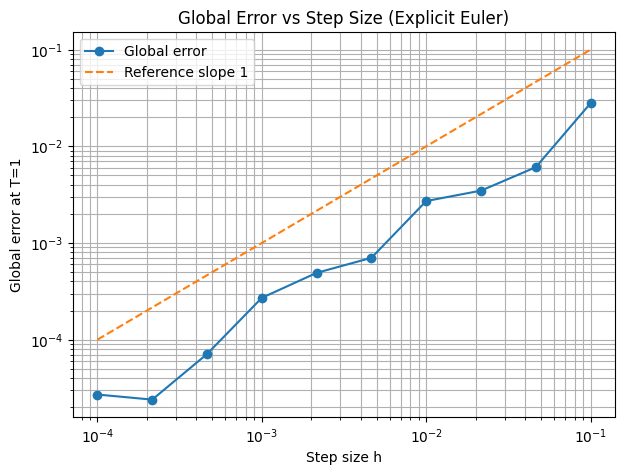

In [ ]:
# Define a simple ODE: dx/dt = -2x
def f(t, x):
    return -2*x

# Analytical solution
def true_solution(t):
    return np.exp(-2*t)

# Explicit Euler method
def euler_step(f, t0, x0, h, N):
    x = x0
    t = t0
    for _ in range(N):
        x = x + h * f(t, x)
        t = t + h
    return x

# Setup
t0 = 0
Tfinal = 1
x0 = 1

# Test different step sizes
h_values = np.logspace(-4, -1, 10)  # from 1e-4 to 1e-1
errors = []

for h in h_values:
    N = int((Tfinal - t0)/h)
    x_num = euler_step(f, t0, x0, h, N)
    x_true = true_solution(Tfinal)
    error = np.abs(x_num - x_true)
    errors.append(error)

# Plot error vs h
plt.figure(figsize=(7,5))
plt.loglog(h_values, errors, 'o-', label='Global error')
plt.loglog(h_values, h_values, '--', label='Reference slope 1')  # Line of slope 1
plt.xlabel('Step size h')
plt.ylabel('Global error at T=1')
plt.title('Global Error vs Step Size (Explicit Euler)')
plt.grid(True, which='both')
plt.legend()
plt.show()


## Explicit solver with fixed and adaptive step

In [ ]:
def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    # Error controller parameters
    epstol = 0.8  # Safety factor
    facmin = 0.1  # Maximum decrease factor
    facmax = 5.0  # Maximum increase factor

    # Integration interval
    t0, tf = tspan

    # Initial conditions
    t = t0
    h = h0
    x = np.array(x0, dtype=float)  # Ensure x is a NumPy array

    # Counters
    nfun = 0
    naccept = 0
    nreject = 0

    # Output storage
    T = np.array([t])  # Ensure T is a 1D NumPy array
    X = np.array([x])  # Ensure X is a 2D NumPy array

    # Algorithm
    while t < tf:
        if t + h > tf:
            h = tf - t

        f = np.array(fun(t, x, *args), dtype=float)  # Ensure f is a NumPy array

        AcceptStep = False

        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h

            tm = t + hm
            xm = x + hm * f

            fm = np.array(fun(tm, xm, *args), dtype=float)  # Ensure fm is a NumPy array
            nfun += 3
            x1hat = xm + hm * fm

            # Error estimation
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)  # Fix element-wise max
            r = np.max(np.abs(e) / denom)  # Compute max ratio

            AcceptStep = r <= epstol

            if AcceptStep:
                t = t + h
                x = x1hat

                naccept += 1
                T = np.append(T, t)  # Append t to the 1D array
                X = np.vstack([X, x1hat.reshape(1, -1)])  # Ensure correct shape
            else:
                nreject += 1

            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    return T, X



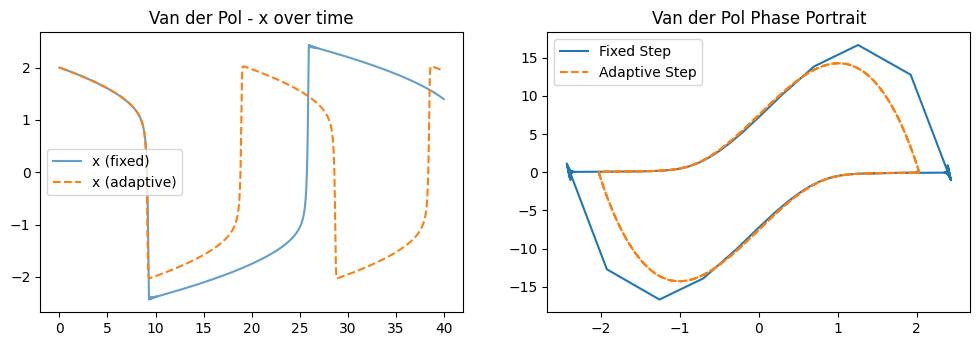

In [43]:
##now running both with code for chatgbt


import numpy as np
import matplotlib.pyplot as plt


def ExplicitEulerFixedStep(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)

    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)

    T[0] = t0
    X[0, :] = x0

    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt

    return T, X


def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0

    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)

    nfun = 0
    naccept = 0
    nreject = 0

    T = np.array([t])
    X = np.array([x])

    while t < tf:
        if t + h > tf:
            h = tf - t

        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False

        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            nfun += 3

            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol

            if AcceptStep:
                t = t + h
                x = x1hat
                naccept += 1
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
            else:
                nreject += 1

            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    return T, X


def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]


def LotkaVolterra(t, x, alpha, beta, delta, gamma):
    prey, predator = x
    dxdt = alpha * prey - beta * prey * predator
    dydt = delta * prey * predator - gamma * predator
    return [dxdt, dydt]


# Parameters and initial conditions
mu = 10
x0_vdp = [2.0, 0.0]
tspan = (0, 40)
N = 1000 #har sat den extra lidt lavere

# Van der Pol - Fixed Step
T1, X1 = ExplicitEulerFixedStep(VanDerPol, tspan[0], tspan[1], N, x0_vdp, mu)
# Van der Pol - Adaptive Step
T2, X2 = ExplicitEulerAdaptiveStep(VanDerPol, tspan, x0_vdp, 0.04, 1e-6, 1e-3, mu)

T3, X3 = ExplicitEulerAdaptiveStep(VanDerPol, tspan, x0_vdp, 0.04, 1e-6, 1e-3, mu)


# Prey-Predator model
x0_lv = [40, 9]
alpha, beta, delta, gamma = 0.1, 0.02, 0.01, 0.1

# Lotka-Volterra - Fixed Step
#T3, X3 = ExplicitEulerFixedStep(LotkaVolterra, tspan[0], tspan[1], N, x0_lv, alpha, beta, delta, gamma)
# Lotka-Volterra - Adaptive Step
#T4, X4 = ExplicitEulerAdaptiveStep(LotkaVolterra, tspan, x0_lv, 0.1, 1e-6, 1e-3, alpha, beta, delta, gamma)

# Plotting
plt.figure(figsize=(12, 8))

# Van der Pol
plt.subplot(2, 2, 1)
plt.plot(T1, X1[:, 0], label='x (fixed)', alpha=0.7)
plt.plot(T2, X2[:, 0], label='x (adaptive)', linestyle='dashed')
plt.title("Van der Pol - x over time")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(X1[:, 0], X1[:, 1], label='Fixed Step')
plt.plot(X2[:, 0], X2[:, 1], label='Adaptive Step', linestyle='dashed')
plt.title("Van der Pol Phase Portrait")
plt.legend()

# Lotka-Volterra
#plt.subplot(2, 2, 3)
#plt.plot(T3, X3[:, 0], label='Prey (fixed)')
#plt.plot(T3, X3[:, 1], label='Predator (fixed)')
#plt.plot(T4, X4[:, 0], '--', label='Prey (adaptive)')
#plt.plot(T4, X4[:, 1], '--', label='Predator (adaptive)')
#3plt.title("Lotka-Volterra - Populations over time")
#plt.legend()

#plt.subplot(2, 2, 4)
#plt.plot(X3[:, 0], X3[:, 1], label='Fixed Step')
#plt.plot(X4[:, 0], X4[:, 1], label='Adaptive Step', linestyle='dashed')
#plt.title("Lotka-Volterra Phase Portrait")
#3plt.legend()

#plt.tight_layout()
#plt.show()

###fucking include baseline



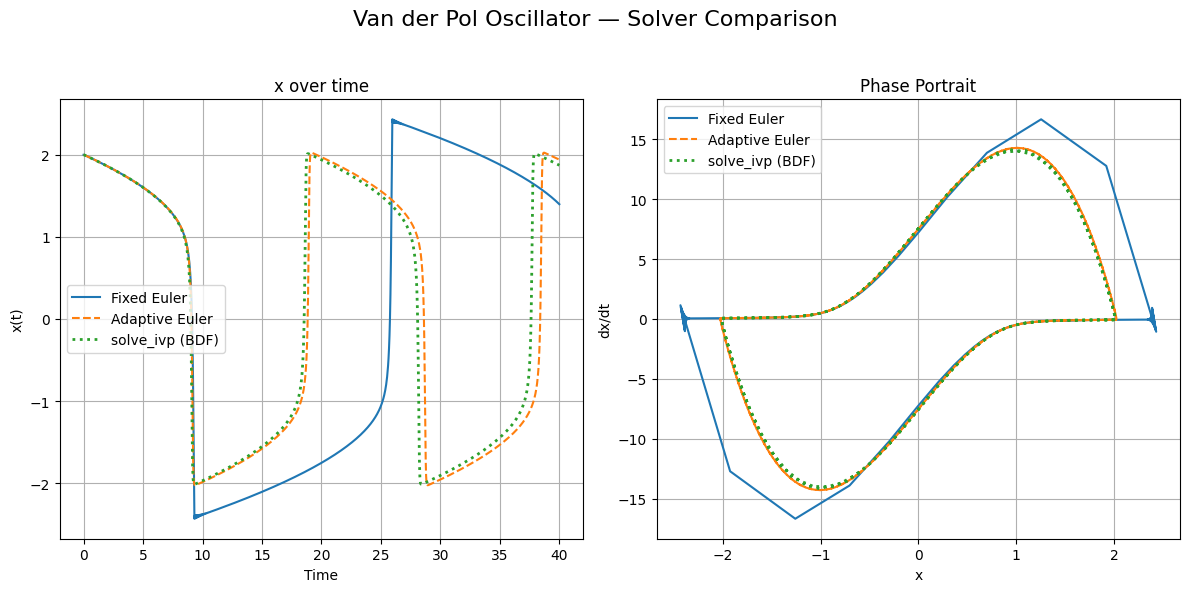

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ExplicitEulerFixedStep(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin, facmax = 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)
    T = [t]
    X = [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            hm, tm = 0.5 * h, t + 0.5 * h
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

# Van der Pol definition
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0]**2) * x[1] - x[0]]

# Parameters
mu = 10
x0_vdp = [2.0, 0.0]
tspan = (0, 40)
N = 1000

# Fixed and adaptive Euler
T1, X1 = ExplicitEulerFixedStep(VanDerPol, tspan[0], tspan[1], N, x0_vdp, mu)
T2, X2 = ExplicitEulerAdaptiveStep(VanDerPol, tspan, x0_vdp, 0.04, 1e-6, 1e-3, mu)

# Benchmark using solve_ivp (BDF)
t_eval = np.linspace(tspan[0], tspan[1], 2000)
sol_ref = solve_ivp(lambda t, x: VanDerPol(t, x, mu), tspan, x0_vdp, method='BDF',
                    t_eval=t_eval, rtol=1e-10, atol=1e-12)

# Plotting
plt.figure(figsize=(12, 6))
plt.suptitle("Van der Pol Oscillator — Solver Comparison", fontsize=16)

# x(t) time evolution
plt.subplot(1, 2, 1)
plt.plot(T1, X1[:, 0], label='Fixed Euler', lw=1.5)
plt.plot(T2, X2[:, 0], label='Adaptive Euler', linestyle='--', lw=1.5)
plt.plot(sol_ref.t, sol_ref.y[0], label='solve_ivp (BDF)', linestyle=':', lw=2)
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('x over time')
plt.legend()
plt.grid(True)

# Phase portrait
plt.subplot(1, 2, 2)
plt.plot(X1[:, 0], X1[:, 1], label='Fixed Euler', lw=1.5)
plt.plot(X2[:, 0], X2[:, 1], label='Adaptive Euler', linestyle='--', lw=1.5)
plt.plot(sol_ref.y[0], sol_ref.y[1], label='solve_ivp (BDF)', linestyle=':', lw=2)
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.title('Phase Portrait')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


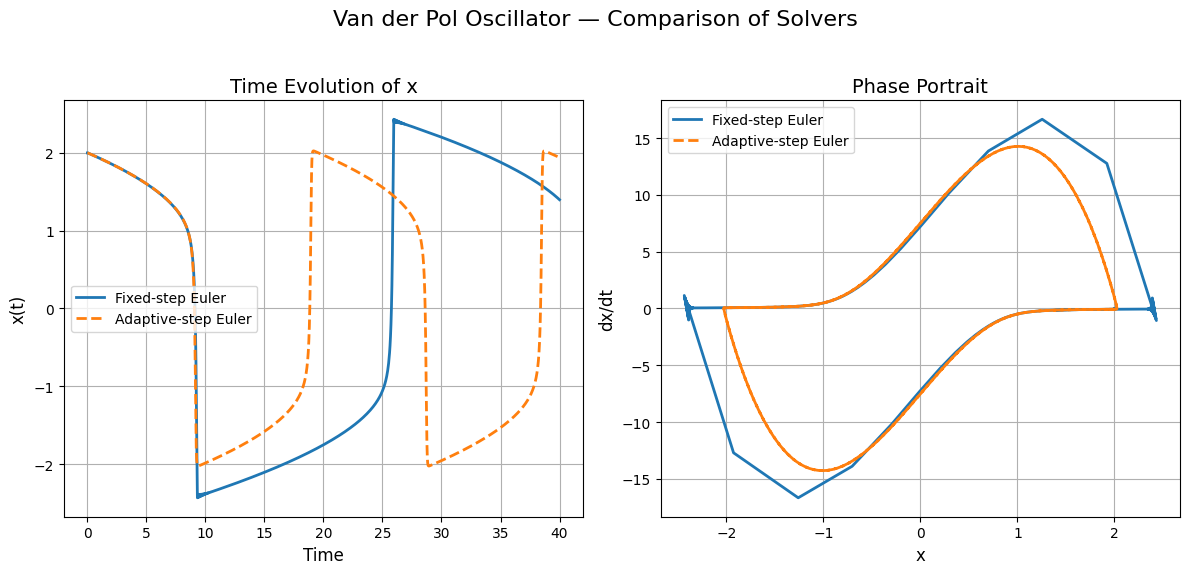

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.suptitle("Van der Pol Oscillator — Comparison of Solvers", fontsize=16)

# Time evolution of x(t)
plt.subplot(1, 2, 1)
plt.plot(T1, X1[:, 0], label='Fixed-step Euler', color='tab:blue', lw=2)
plt.plot(T2, X2[:, 0], label='Adaptive-step Euler', linestyle='--', color='tab:orange', lw=2)
plt.xlabel("Time", fontsize=12)
plt.ylabel("x(t)", fontsize=12)
plt.title("Time Evolution of x", fontsize=14)
plt.legend()
plt.grid(True)

# Phase portrait
plt.subplot(1, 2, 2)
plt.plot(X1[:, 0], X1[:, 1], label='Fixed-step Euler', color='tab:blue', lw=2)
plt.plot(X2[:, 0], X2[:, 1], label='Adaptive-step Euler', linestyle='--', color='tab:orange', lw=2)
plt.xlabel("x", fontsize=12)
plt.ylabel("dx/dt", fontsize=12)
plt.title("Phase Portrait", fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13852\2016944497.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2, color='blue')


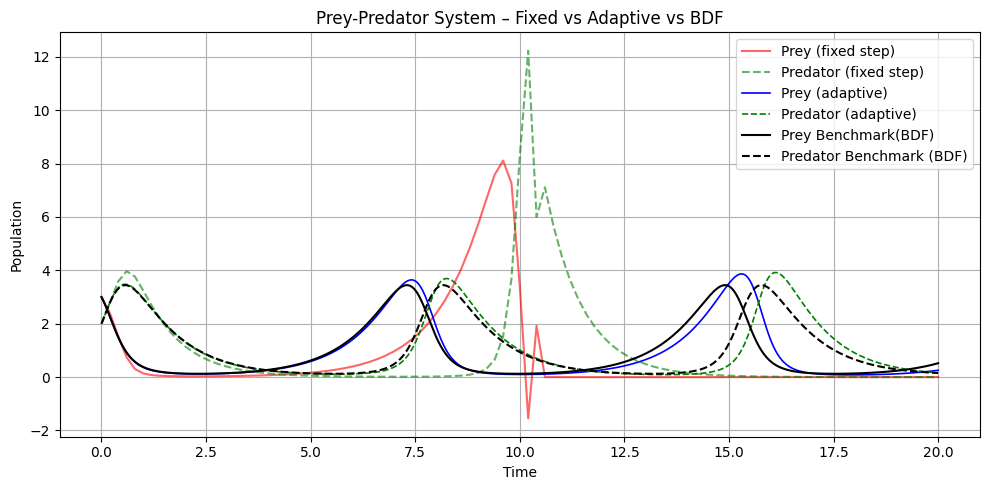

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Van der Pol ODE and Jacobian
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

def VanDerPol_Jac(t, x, mu):
    return np.array([
        [0, 1],
        [-1 - 2 * mu * x[0] * x[1], mu * (1 - x[0] ** 2)]
    ])

# Prey-Predator ODE and Jacobian
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

def PreyPredator_Jac(t, x, a, b):
    x1, x2 = x
    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    return [[dx1x1, dx1x2], [dx2x1, dx2x2]]

# Explicit Euler methods (fixed and adaptive)
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)
    T = np.array([t])
    X = np.array([x])
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t = t + h
                x = x1hat
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h
    return T, X

# Problem setup
tspan = (0, 20)
t_eval = np.linspace(tspan[0], tspan[1], 1000)

# --- Van der Pol ---
mu = 1000
x0_vdp = [2.0, 0.0]

sol_vdp_bdf = solve_ivp(
    VanDerPol, tspan, x0_vdp, args=(mu,), method='BDF',
    jac=VanDerPol_Jac, t_eval=t_eval, rtol=1e-9, atol=1e-12
)


# --- Prey-Predator ---
a, b = 1.0, 1.0
x0_pp = [3.0, 2.0]
N_pp = 100

T3, X3 = explicit_euler_fixed_step_size(PreyPredator, tspan[0], tspan[1], N_pp, x0_pp, a, b)
T4, X4 = ExplicitEulerAdaptiveStep(PreyPredator, tspan, x0_pp, 0.1, 1e-6, 1e-3, a, b)

sol_pp_bdf = solve_ivp(
    PreyPredator, tspan, x0_pp, args=(a, b), method='BDF',
    jac=PreyPredator_Jac, t_eval=t_eval, rtol=1e-9, atol=1e-12
)

# plt.figure(figsize=(10, 5))
# plt.plot(T3, X3[:, 0], 'r', label='Prey (fixed step)', alpha=0.6)
# plt.plot(T3, X3[:, 1],'--',label='Predator (fixed step)', alpha=0.6)
# plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2)
# plt.plot(T4, X4[:, 1], 'g--', label='Predator (adaptive)', linewidth=1.2)
# plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[0], 'k', label='Prey Benchmark(BDF)', linewidth=1.5)
# plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[1], 'k--', label='Predator Benchmark (BDF)', linewidth=1.5)
# plt.title("Prey-Predator System – Fixed vs Adaptive vs BDF")
# plt.xlabel("Time")
# plt.ylabel("Population")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()


plt.figure(figsize=(10, 5))
plt.plot(T3, X3[:, 0], label='Prey (fixed step)', alpha=0.6, color='red')
plt.plot(T3, X3[:, 1],'--',label='Predator (fixed step)', alpha=0.6, color='green')
plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2, color='blue')
plt.plot(T4, X4[:, 1], 'g--', label='Predator (adaptive)', linewidth=1.2)
plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[0], 'k', label='Prey Benchmark(BDF)', linewidth=1.5)
plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[1], 'k--', label='Predator Benchmark (BDF)', linewidth=1.5)
plt.title("Prey-Predator System – Fixed vs Adaptive vs BDF")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


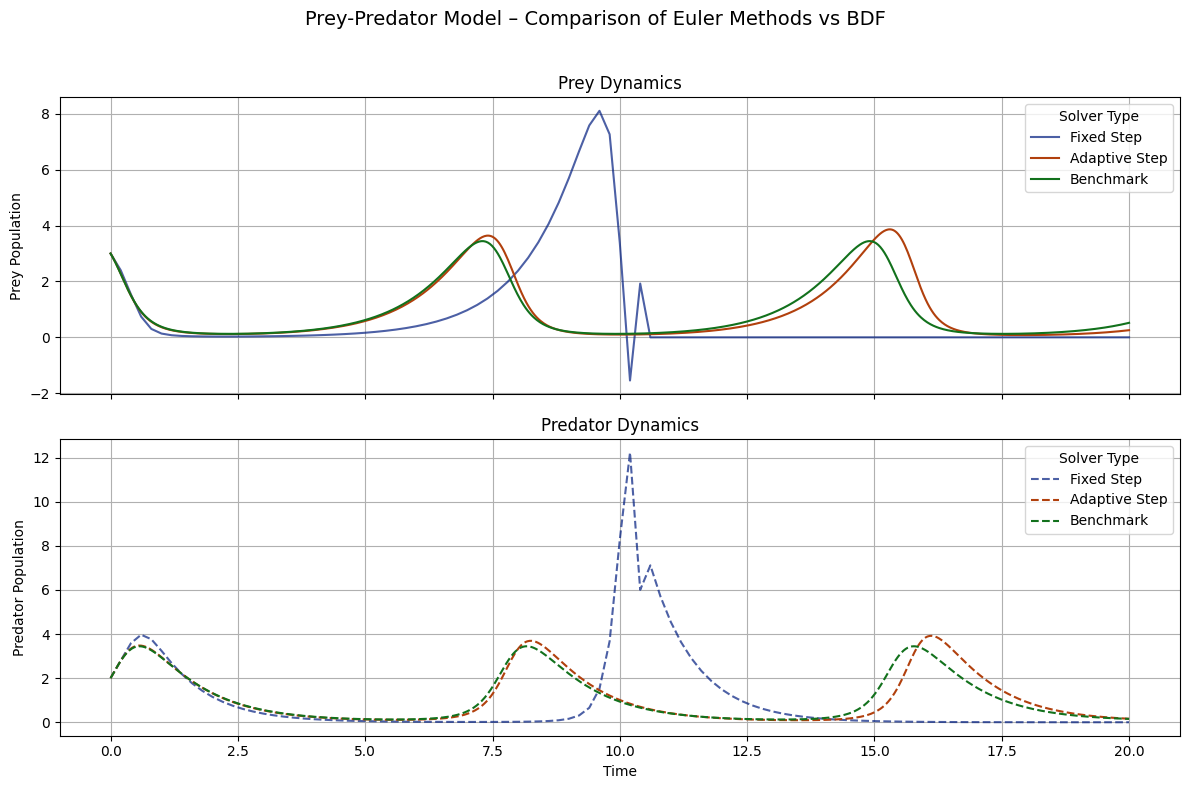

In [ ]:
import seaborn as sns

# Get the first 3 colorblind-friendly colors
colors = sns.color_palette("dark")
fixed_color = colors[0]     
adaptive_color = colors[1]  
bdf_color = colors[2]       


fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Prey subplot
axes[0].plot(T3, X3[:, 0], label='Fixed Step', color=fixed_color, alpha=0.7)
axes[0].plot(T4, X4[:, 0], label='Adaptive Step', color=adaptive_color, linestyle='-')
axes[0].plot(sol_pp_bdf.t, sol_pp_bdf.y[0], label='Benchmark', color=bdf_color, linestyle='-')
axes[0].set_ylabel("Prey Population")
axes[0].set_title("Prey Dynamics")
axes[0].legend(title="Solver Type")
axes[0].grid(True)

# Predator subplot
axes[1].plot(T3, X3[:, 1], label='Fixed Step', color=fixed_color, linestyle='--', alpha=0.7)
axes[1].plot(T4, X4[:, 1], label='Adaptive Step', color=adaptive_color, linestyle='--')
axes[1].plot(sol_pp_bdf.t, sol_pp_bdf.y[1], label='Benchmark', color=bdf_color, linestyle='--')
axes[1].set_ylabel("Predator Population")
axes[1].set_xlabel("Time")
axes[1].set_title("Predator Dynamics")
axes[1].legend(title="Solver Type")
axes[1].grid(True)

plt.suptitle("Prey-Predator Model – Comparison of Euler Methods vs BDF", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13852\2926170577.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Van der Pol Oscillator ($\mu=1000$) – Comparison to BDF")


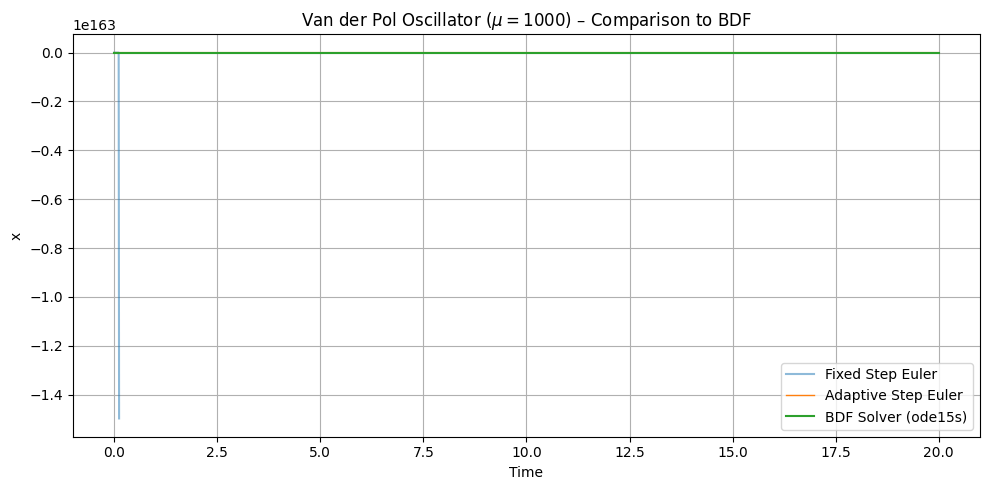

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(T1, X1[:, 0], label='Fixed Step Euler', alpha=0.5)
plt.plot(T2, X2[:, 0], label='Adaptive Step Euler', linewidth=1)
plt.plot(sol_ode15s.t, sol_ode15s.y[0], label='BDF Solver (ode15s)', linewidth=1.5)
plt.title("Van der Pol Oscillator ($\mu=1000$) – Comparison to BDF")
plt.xlabel("Time")
plt.ylabel("x")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## explicit solvers


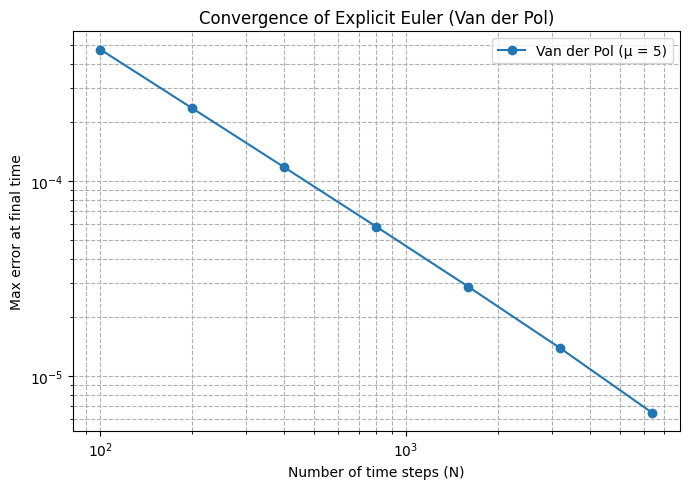

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Van der Pol model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

# --- Fixed-step explicit Euler solver ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Reference solution using very fine step ---
mu = 5.0
x0 = [2.0, 0.0]
t0, tf = 0.0, 2.0
N_ref = 50000
_, X_ref = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N_ref, x0, mu)
x_ref_final = X_ref[-1]

# --- Convergence test: errors vs. number of steps ---
N_values = [100, 200, 400, 800, 1600, 3200, 6400]
errors = []

for N in N_values:
    _, X = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N, x0, mu)
    err = np.max(np.abs(X[-1] - x_ref_final))
    errors.append(err)

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.loglog(N_values, errors, marker='o', label='Van der Pol (μ = 5)')
plt.xlabel("Number of time steps (N)")
plt.ylabel("Max error at final time")
plt.title("Convergence of Explicit Euler (Van der Pol)")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


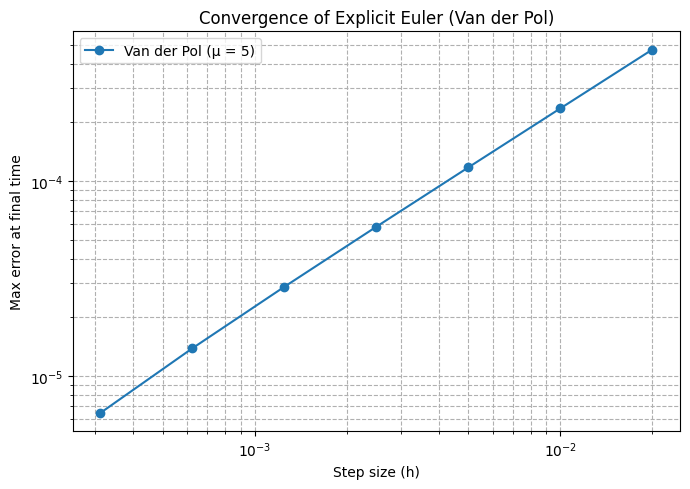

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Van der Pol model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

# --- Fixed-step explicit Euler solver ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Setup ---
mu = 5.0
x0 = [2.0, 0.0]
t0, tf = 0.0, 2.0
N_ref = 50000
_, X_ref = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N_ref, x0, mu)
x_ref_final = X_ref[-1]

# --- Convergence analysis ---
N_values = [100, 200, 400, 800, 1600, 3200, 6400]
hs = [(tf - t0) / N for N in N_values]
errors = []

for N in N_values:
    _, X = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N, x0, mu)
    err = np.max(np.abs(X[-1] - x_ref_final))
    errors.append(err)

# --- Plot: error vs. step size ---
plt.figure(figsize=(7, 5))
plt.loglog(hs, errors, marker='o', label='Van der Pol (μ = 5)')
plt.xlabel("Step size (h)")
plt.ylabel("Max error at final time")
plt.title("Convergence of Explicit Euler (Van der Pol)")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


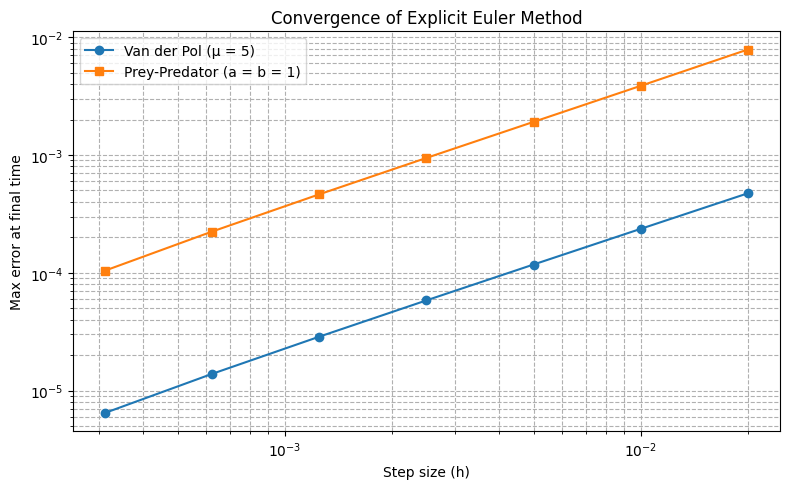

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Van der Pol model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

# --- Prey-Predator model ---
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

# --- Explicit Euler fixed-step solver ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Settings ---
t0, tf = 0.0, 2.0
N_ref = 50000
N_values = [100, 200, 400, 800, 1600, 3200, 6400]
hs = [(tf - t0) / N for N in N_values]

# --- Van der Pol reference ---
mu = 5.0
x0_vdp = [2.0, 0.0]
_, X_ref_vdp = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N_ref, x0_vdp, mu)
x_ref_vdp = X_ref_vdp[-1]

# --- Prey-Predator reference ---
a, b = 1.0, 1.0
x0_pp = [1.5, 1.0]
_, X_ref_pp = explicit_euler_fixed_step_size(PreyPredator, t0, tf, N_ref, x0_pp, a, b)
x_ref_pp = X_ref_pp[-1]

# --- Compute errors for both models ---
errors_vdp = []
errors_pp = []

for N in N_values:
    _, X_vdp = explicit_euler_fixed_step_size(VanDerPol, t0, tf, N, x0_vdp, mu)
    _, X_pp = explicit_euler_fixed_step_size(PreyPredator, t0, tf, N, x0_pp, a, b)
    err_vdp = np.max(np.abs(X_vdp[-1] - x_ref_vdp))
    err_pp = np.max(np.abs(X_pp[-1] - x_ref_pp))
    errors_vdp.append(err_vdp)
    errors_pp.append(err_pp)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.loglog(hs, errors_vdp, marker='o', label="Van der Pol (μ = 5)")
plt.loglog(hs, errors_pp, marker='s', label="Prey-Predator (a = b = 1)")
plt.xlabel("Step size (h)")
plt.ylabel("Max error at final time")
plt.title("Convergence of Explicit Euler Method")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# --- Van der Pol model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

# --- Prey-Predator model ---
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

# --- CSTR 3-state model ---
def CSTR3(t, C_states, params):
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params
    T = max(C_states[2], 1e-3)
    CA, CB, T = C_states
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])
    R = v * r
    dCdt = (Cin - C_states) * F / V + R
    return np.array(dCdt)

# --- CSTR 1-state model ---
def CSTR1(t, T_state, params):
    if isinstance(T_state, list):
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + 1 / beta * (T0 - T_state)
    CB = CB_in + 2 / beta * (T0 - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dTdt = (Tin - T_state) * F / V + beta * r
    return dTdt

# --- PFR 3-state model ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    k0 = np.exp(24.6)
    DA = 0.1
    DB = 0.1
    DT = 0.1

    CA = C[0:n]
    CB = C[n:2 * n]
    T = C[2 * n:3 * n]

    Ea_over_R = 8500
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    NconvA = np.zeros(n + 1)
    NconvA[0] = vol * CAin
    NconvA[1:n + 1] = vol * CA[0:n]

    NconvB = np.zeros(n + 1)
    NconvB[0] = vol * CBin
    NconvB[1:n + 1] = vol * CB[0:n]

    NconvT = np.zeros(n + 1)
    NconvT[0] = vol * Tin
    NconvT[1:n + 1] = vol * T[0:n]

    JA = np.zeros(n + 1)
    JA[1:n] = (-DA / dz) * (CA[1:n] - CA[0:n - 1])

    JB = np.zeros(n + 1)
    JB[1:n] = (-DB / dz) * (CB[1:n] - CB[0:n - 1])

    JT = np.zeros(n + 1)
    JT[1:n] = (-DT / dz) * (T[1:n] - T[0:n - 1])

    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT

    v = p['v']
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    CAdot = (NA[1:n + 1] - NA[0:n]) / (-dz) + RA
    CBdot = (NB[1:n + 1] - NB[0:n]) / (-dz) + RB
    Tdot = (NT[1:n + 1] - NT[0:n]) / (-dz) + RT

    return np.hstack([CAdot, CBdot, Tdot])

# --- PFR 1-state model ---
def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))
    Tin_val = u if np.isscalar(u) else u(t)

    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt


In [13]:
import numpy as np

deltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
Ea_over_R = 8500             # K
k0 = np.exp(24.6)            # L/(mol*s)
V = 0.105                    # L
F = 0.1                      # L/s

C0 = np.array([3.4, 3.7, 200])                             # Initial
Cin = C0 + np.array([0.03, -0.04, -10])                    # Inlet

CSTR3_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin)
x0_cstr3 = C0.copy()


In [14]:
CA_in = 1.6 / 2
CB_in = 2.4 / 2
T0 = 273.15
Tin = 273.15



CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)
x0_cstr1 = [T0]


In [15]:
Nz = 20
L = 10
deltaz = L / Nz
F_pfr = 50

beta = -deltaHr / (rho * cp)
v_vec = np.array([-1, -2, beta])

p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v_vec,
    'F': F_pfr
}

CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0_pfr3 = np.full(Nz, 200)
C0_pfr = np.concatenate([CA0, CB0, T0_pfr3])
Cin = np.array([1.6, 2.4, 350])

x0_pfr3 = C0_pfr.copy()


In [18]:
params = {
    "Nz": Nz,
    "dz": deltaz,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T
}

T0_pfr1 = np.ones(Nz) * 300.0
x0_pfr1 = T0_pfr1.copy()


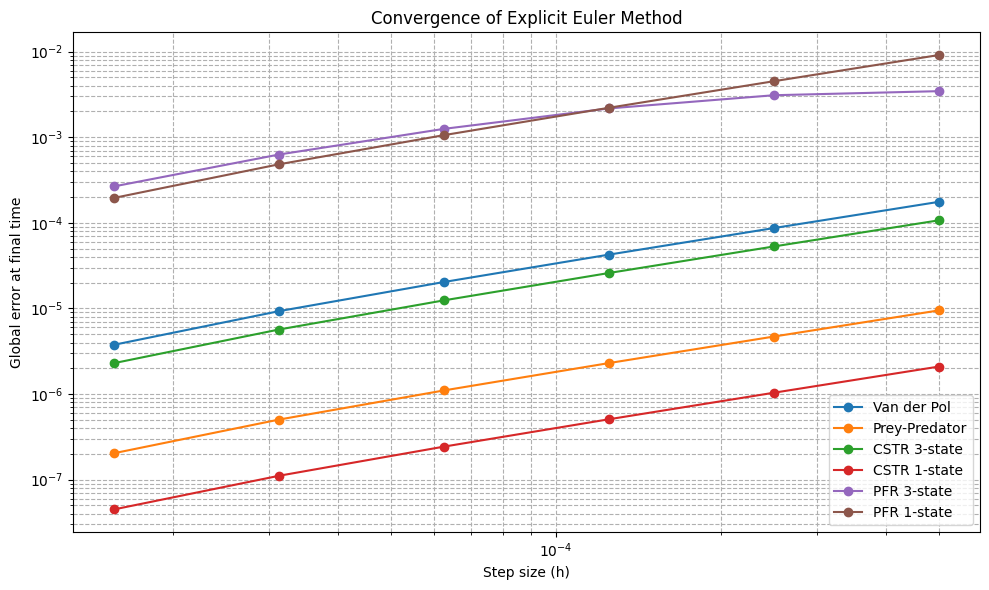

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- Explicit Euler Fixed-Step Solver ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Wrappers for each model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

def CSTR3_fun(t, x):
    return CSTR3(t, x, CSTR3_PARAMS)

def CSTR1_fun(t, x):
    return [CSTR1(t, x[0], CSTR1_PARAMS)]

def PFR3_fun(t, x):
    return PFR_3state(t, x, Cin, p)

def PFR1_fun(t, x):
    return PFR1(t, x, Tin, params)

# --- Simulation settings ---
t0, tf = 0, 0.05
N_ref = 10000
N_vals = [100, 200, 400, 800, 1600, 3200]
hs = [(tf - t0) / N for N in N_vals]

# --- Initial states ---
mu = 5
a, b = 1.0, 1.0
x0_vdp = [2.0, 0.0]
x0_pp = [1.5, 1.0]

CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0_pfr3 = np.full(Nz, 200)
C0_pfr = np.concatenate([CA0, CB0, T0_pfr3])

x0_pfr3 = C0_pfr.copy()


# Replace T0, C0, etc., with your correct initial states
##x0_cstr3 = C0
##x0_cstr1 = [T0]
#x0_pfr3 = C0
#x0_pfr1 = T0.copy()

# --- Model configurations ---
models = [
    ("Van der Pol", VanDerPol, x0_vdp, (mu,)),
    ("Prey-Predator", PreyPredator, x0_pp, (a, b)),
    ("CSTR 3-state", CSTR3_fun, x0_cstr3, ()),
    ("CSTR 1-state", CSTR1_fun, x0_cstr1, ()),
    ("PFR 3-state", PFR3_fun, x0_pfr3, ()),
    ("PFR 1-state", PFR1_fun, x0_pfr1, ())
]

# --- Run and collect errors ---
error_dict = {}

for name, model, x0, args in models:
    _, X_ref = explicit_euler_fixed_step_size(model, t0, tf, N_ref, x0, *args)
    x_ref_final = X_ref[-1]
    errors = []
    for N in N_vals:
        _, X = explicit_euler_fixed_step_size(model, t0, tf, N, x0, *args)
        err = np.max(np.abs(X[-1] - x_ref_final))
        errors.append(err)
    error_dict[name] = errors

# --- Plot results ---
plt.figure(figsize=(10, 6))
for name, errors in error_dict.items():
    plt.loglog(hs, errors, marker='o', label=name)

plt.xlabel("Step size (h)")
plt.ylabel("Global error at final time")
plt.title("Convergence of Explicit Euler Method")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


Adaptive 

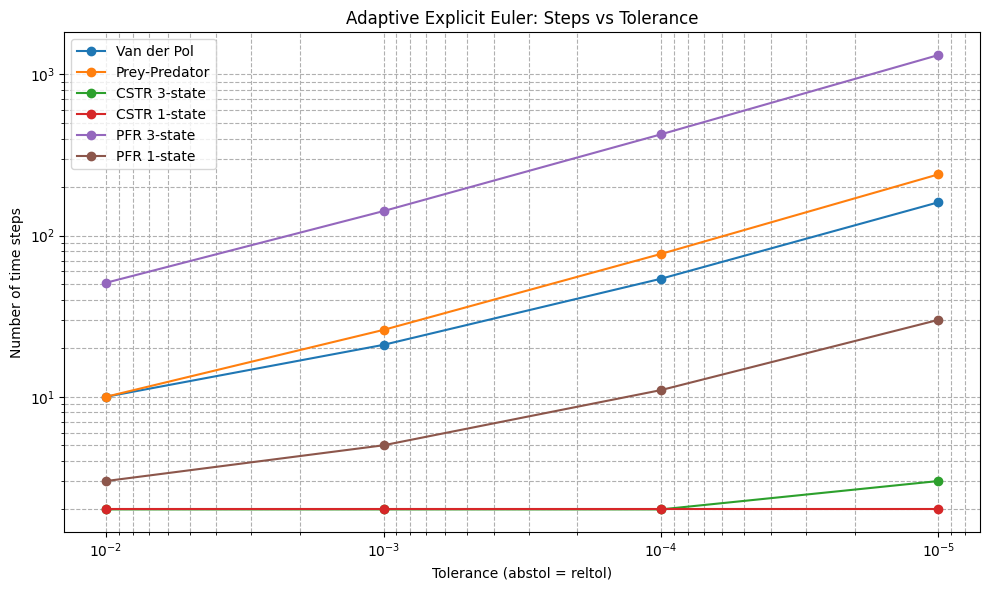

In [26]:
# Now rerun the step count vs tolerance plot with all models
def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)
    T = np.array([t])
    X = np.array([x])
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t = t + h
                x = x1hat
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h
    return T, X


# Redefine the remaining model functions (already done earlier)
def CSTR1(t, T_state, params):
    if isinstance(T_state, list):
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0_val, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + 1 / beta * (T0_val - T_state)
    CB = CB_in + 2 / beta * (T0_val - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dTdt = (Tin - T_state) * F / V + beta * r
    return [dTdt]

def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A
    k0 = np.exp(24.6)
    DA = DB = DT = 0.1
    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
    Ea_over_R = 8500
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    NconvA = np.zeros(n+1); NconvA[0] = vol * CAin; NconvA[1:] = vol * CA
    NconvB = np.zeros(n+1); NconvB[0] = vol * CBin; NconvB[1:] = vol * CB
    NconvT = np.zeros(n+1); NconvT[0] = vol * Tin;  NconvT[1:] = vol * T
    JA = np.zeros(n+1); JA[1:n] = (-DA/dz) * (CA[1:] - CA[:-1])
    JB = np.zeros(n+1); JB[1:n] = (-DB/dz) * (CB[1:] - CB[:-1])
    JT = np.zeros(n+1); JT[1:n] = (-DT/dz) * (T[1:] - T[:-1])
    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT
    v = p['v']
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r
    CAdot = (NA[1:] - NA[:-1]) / -dz + RA
    CBdot = (NB[1:] - NB[:-1]) / -dz + RB
    Tdot = (NT[1:] - NT[:-1]) / -dz + RT
    return np.hstack([CAdot, CBdot, Tdot])

def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))
    Tin_val = u if np.isscalar(u) else u(t)
    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]
    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt

# Run the plot again
tspan_map = {
    "Van der Pol": (0, 2.0),
    "Prey-Predator": (0, 2.0),
    "CSTR 3-state": (0, 0.05),
    "CSTR 1-state": (0, 0.05),
    "PFR 3-state": (0, 0.05),
    "PFR 1-state": (0, 0.1),
}

model_configs = [
    ("Van der Pol", VanDerPol, [2.0, 0.0], (5.0,)),
    ("Prey-Predator", PreyPredator, [1.5, 1.0], (1.0, 1.0)),
    ("CSTR 3-state", CSTR3, C0.copy(), (CSTR3_PARAMS,)),
    ("CSTR 1-state", lambda t, x, p: CSTR1(t, x, p), [T0], (CSTR1_PARAMS,)),
    ("PFR 3-state", lambda t, x, cin, p: PFR_3state(t, x, cin, p), C0_pfr.copy(), (Cin, p)),
    ("PFR 1-state", lambda t, x, u, p: PFR1(t, x, u, params), T0_pfr1.copy(), (Tin, params)),
]

tolerances = [1e-2, 1e-3, 1e-4, 1e-5]
step_counts = {}

for name, model, x0, args in model_configs:
    steps = []
    for tol in tolerances:
        t_use = tspan_map[name]
        T, X = ExplicitEulerAdaptiveStep(model, t_use, x0, 0.1, tol, tol, *args)
        steps.append(len(T))
    step_counts[name] = steps

# Plot
plt.figure(figsize=(10, 6))
for name, counts in step_counts.items():
    plt.loglog(tolerances, counts, marker='o', label=name)

plt.xlabel("Tolerance (abstol = reltol)")
plt.ylabel("Number of time steps")
plt.title("Adaptive Explicit Euler: Steps vs Tolerance")
plt.gca().invert_xaxis()
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# --- Van der Pol model ---
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

# --- Prey-Predator model ---
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

# --- CSTR 3-state model ---
def CSTR3(t, C_states, params):
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params
    T = max(C_states[2], 1e-3)
    CA, CB, T = C_states
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])
    R = v * r
    dCdt = (Cin - C_states) * F / V + R
    return np.array(dCdt)

# --- CSTR 1-state model ---
def CSTR1(t, T_state, params):
    if isinstance(T_state, (list, np.ndarray)):
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0_val, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + 1 / beta * (T0_val - T_state)
    CB = CB_in + 2 / beta * (T0_val - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dTdt = (Tin - T_state) * F / V + beta * r
    return np.array([dTdt], dtype=float)  # wrapped as list for adaptive solver

# --- PFR 3-state model ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    k0 = np.exp(24.6)
    DA = 0.1
    DB = 0.1
    DT = 0.1

    CA = C[0:n]
    CB = C[n:2 * n]
    T = C[2 * n:3 * n]

    Ea_over_R = 8500
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    NconvA = np.zeros(n + 1)
    NconvA[0] = vol * CAin
    NconvA[1:n + 1] = vol * CA[0:n]

    NconvB = np.zeros(n + 1)
    NconvB[0] = vol * CBin
    NconvB[1:n + 1] = vol * CB[0:n]

    NconvT = np.zeros(n + 1)
    NconvT[0] = vol * Tin
    NconvT[1:n + 1] = vol * T[0:n]

    JA = np.zeros(n + 1)
    JA[1:n] = (-DA / dz) * (CA[1:n] - CA[0:n - 1])

    JB = np.zeros(n + 1)
    JB[1:n] = (-DB / dz) * (CB[1:n] - CB[0:n - 1])

    JT = np.zeros(n + 1)
    JT[1:n] = (-DT / dz) * (T[1:n] - T[0:n - 1])

    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT

    v = p['v']
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    CAdot = (NA[1:n + 1] - NA[0:n]) / (-dz) + RA
    CBdot = (NB[1:n + 1] - NB[0:n]) / (-dz) + RB
    Tdot = (NT[1:n + 1] - NT[0:n]) / (-dz) + RT

    return np.hstack([CAdot, CBdot, Tdot])

# --- PFR 1-state model ---
def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))
    Tin_val = u if np.isscalar(u) else u(t)

    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt


In [ ]:
def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    max_steps = 100000

    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)
    T = np.array([t])
    X = np.array([x])

    step_counter = 0
    while t < tf and step_counter < max_steps:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t += h
                x = x1hat
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
                step_counter += 1
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    if step_counter >= max_steps:
        print("Warning: maximum number of steps reached before final time.")

    return T, X


In [37]:
def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    max_steps = 100000
    max_rejects = 1000  # prevent infinite inner loop

    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)
    T = np.array([t])
    X = np.array([x])

    step_counter = 0
    while t < tf and step_counter < max_steps:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        reject_counter = 0

        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol

            if AcceptStep:
                t += h
                x = x1hat
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
                step_counter += 1
            else:
                h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h
                reject_counter += 1
                if reject_counter >= max_rejects:
                    print(f"Warning: step rejected too many times at t={t:.5f}. Aborting.")
                    return T, X

    if step_counter >= max_steps:
        print("Warning: maximum number of steps reached before final time.")

    return T, X


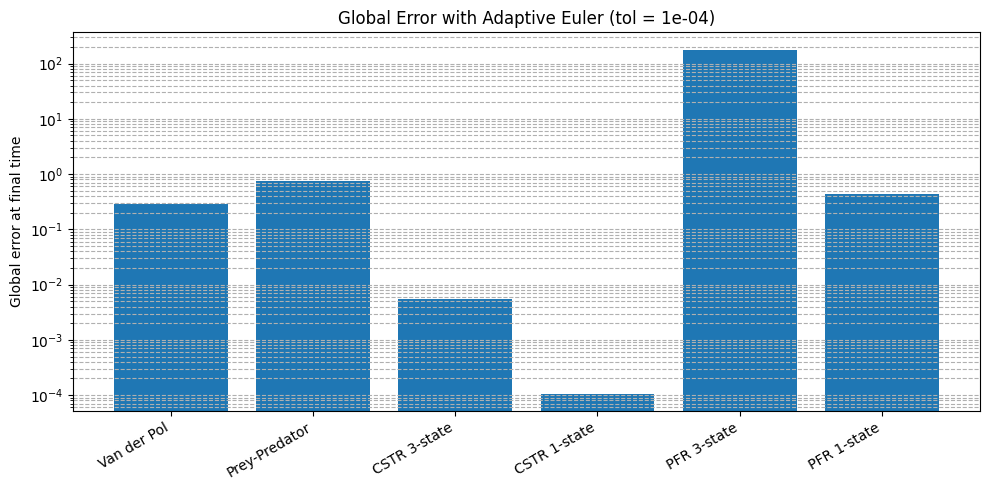

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Set the tolerance for comparison
target_tol = 1e-4
ref_tol = 1e-10

# Prepare to collect final-time global errors
global_errors = {}

# Rerun for each model
for name, model, x0, args in model_configs:
    t_use = tspan_map[name]

    # Reference solution
    T_ref, X_ref = ExplicitEulerAdaptiveStep(model, t_use, x0, 0.01, ref_tol, ref_tol, *args)
    x_ref_final = X_ref[-1]

    # Solution at target tolerance
    T_test, X_test = ExplicitEulerAdaptiveStep(model, t_use, x0, 0.1, target_tol, target_tol, *args)
    x_test_final = X_test[-1]

    # Global error at final time
    err = np.max(np.abs(x_test_final - x_ref_final))
    global_errors[name] = err

# --- Plot global error per model ---
plt.figure(figsize=(10, 5))
model_names = list(global_errors.keys())
errors = list(global_errors.values())

plt.bar(model_names, errors)
plt.yscale("log")
plt.ylabel("Global error at final time")
plt.title(f"Global Error with Adaptive Euler (tol = {target_tol:.0e})")
plt.xticks(rotation=30, ha="right")
plt.grid(True, which="both", linestyle="--", axis="y")
plt.tight_layout()
plt.show()


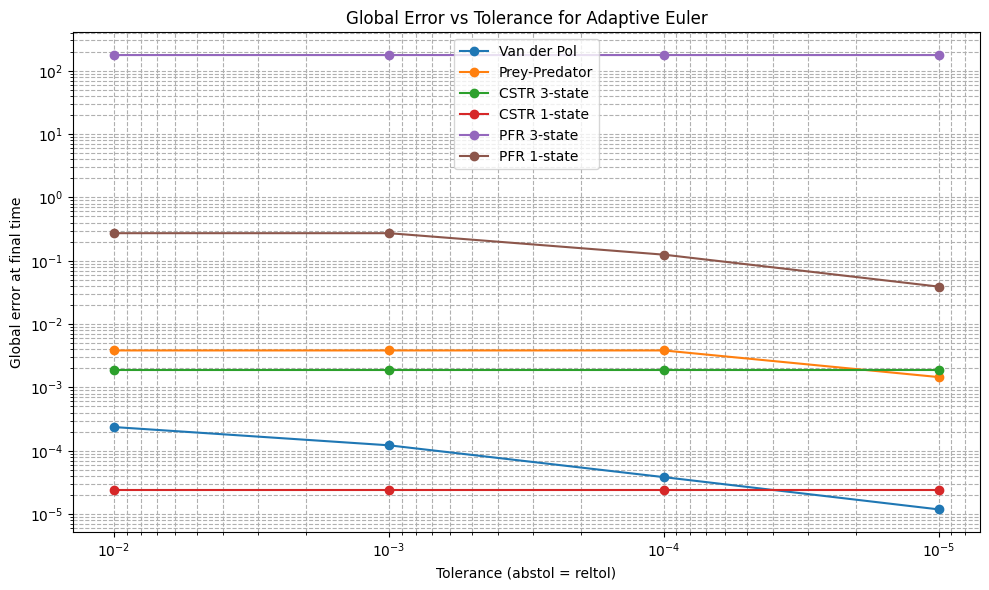

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Set tolerances to test and a more practical reference tolerance
tolerances = [1e-2, 1e-3, 1e-4, 1e-5]
ref_tol = 1e-8

# Dictionary to store errors per model
error_table = {name: [] for name, *_ in model_configs}

# Loop over tolerances and compute final-time error vs reference
for target_tol in tolerances:
    for name, model, x0, args in model_configs:
        t_use = tspan_map[name]

        # High-accuracy reference solution
        T_ref, X_ref = ExplicitEulerAdaptiveStep(model, t_use, x0, 0.01, ref_tol, ref_tol, *args)
        x_ref_final = X_ref[-1]

        # Test solution at current tolerance
        T_test, X_test = ExplicitEulerAdaptiveStep(model, t_use, x0, 0.02, target_tol, target_tol, *args)
        x_test_final = X_test[-1]

        # Compute global error at final time
        err = np.max(np.abs(x_test_final - x_ref_final))
        error_table[name].append(err)

# --- Plot global error vs tolerance ---
plt.figure(figsize=(10, 6))
for name, errors in error_table.items():
    plt.loglog(tolerances, errors, marker='o', label=name)

plt.xlabel("Tolerance (abstol = reltol)")
plt.ylabel("Global error at final time")
plt.title("Global Error vs Tolerance for Adaptive Euler")
plt.grid(True, which="both", linestyle="--")
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()


CSTR 3

FIrst one done
Second one done
Last one done


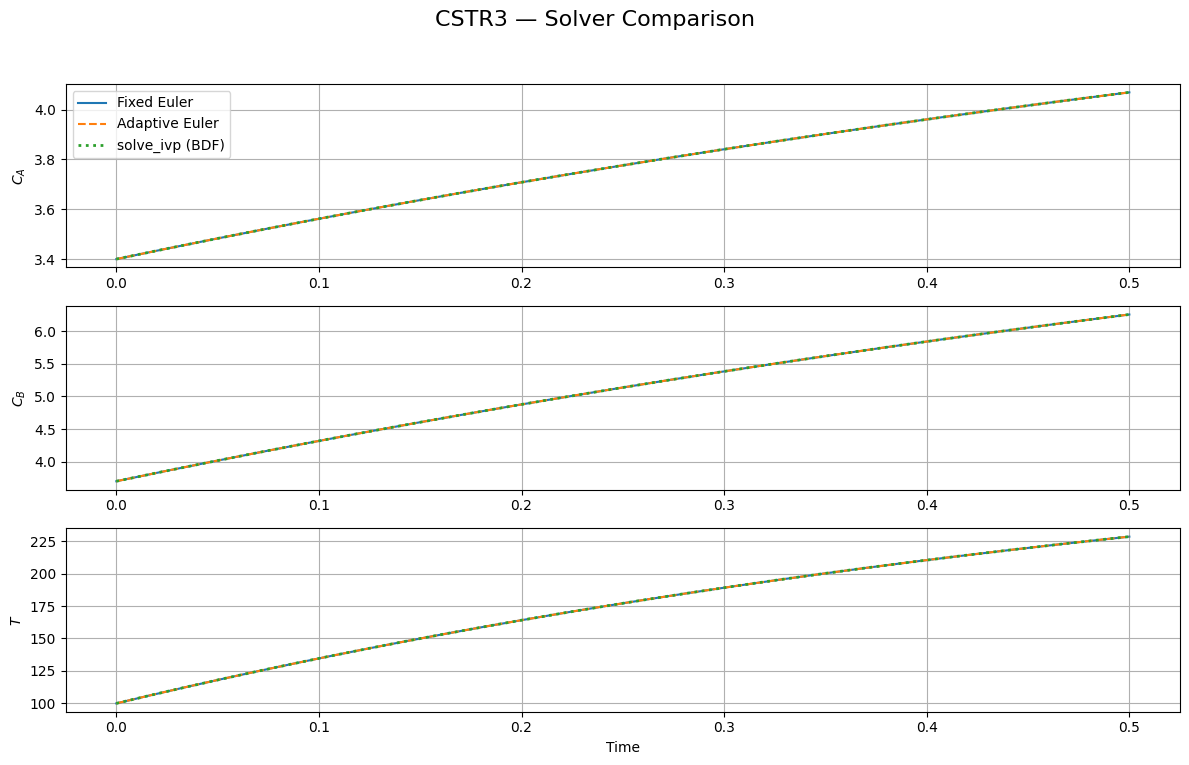

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# CSTR3 Model
def CSTR3(t, x, p):
    CA, CB, T = x
    k0 = np.exp(24.6)
    Ea_R = 8500
    k = k0 * np.exp(-Ea_R / T)
    r = k * CA * CB

    dCA = p['q'] * (p['CAf'] - CA) - r
    dCB = p['q'] * (p['CBf'] - CB) - r
    dT = p['q'] * (p['Tf'] - T) + (-p['dH'] * r) / (p['rho'] * p['Cp']) + p['UA'] * (p['Tc'] - T) / (p['rho'] * p['Cp'])

    return np.array([dCA, dCB, dT])

# Explicit Euler (Fixed)
def ExplicitEulerFixed(fun, t0, tf, N, x0, *args):
    dt = (tf - t0) / N
    T = np.linspace(t0, tf, N + 1)
    X = np.zeros((N + 1, len(x0)))
    X[0] = x0
    for k in range(N):
        X[k + 1] = X[k] + dt * fun(T[k], X[k], *args)
    return T, X

# Explicit Euler (Adaptive)
def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol, facmin, facmax = 0.8, 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)
    T = [t]
    X = [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args))
        Accept = False
        while not Accept:
            x1 = x + h * f
            hm, tm = 0.5 * h, t + 0.5 * h
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args))
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            Accept = r <= epstol
            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

# Parameters
params = {
    'q': 1.0,
    'CAf': 5.1,
    'CBf': 10.2,
    'Tf': 350.0,
    'Tc': 300.0,
    'UA': 150.0,
    'rho': 1000.0,
    'Cp': 0.239,
    'dH': -5e4
}

eltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
Ea_over_R = 8500             # K
k0 = np.exp(24.6)            # L/(mol*s)
V = 0.105                    # L (from Wahlgreen 2020)
F = 0.1                      # L/s  (assumed constant flowrate, realistic)

# initialisations
C0 = np.array([3.4, 3.7, 200])          # Initial condition
Cin = C0 + np.array([0.03, -0.04, -10])     # Assume inlet concentration = initial for now

#CSTR3_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin)
#CSTR3_param_type = Tuple[float, float, float, float, float, float, float, np.ndarray]

# --- Parameters (your version) ---
deltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
Ea_over_R = 8500             # K
k0 = np.exp(24.6)            # L/(mol*s)
V = 0.105                    # L
F = 0.1                      # L/s

C0 = np.array([3.4, 3.7, 200])
Cin = C0 + np.array([0.03, -0.04, -10])
CSTR3_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin)

# Initial conditions and simulation settings
x0 = np.array([3.4, 3.7, 100])
tspan = (0, 0.5)
t_eval = np.linspace(*tspan, 10000)
N = 100000  # Fixed step divisions

# Solve all

T_fixed, X_fixed = ExplicitEulerFixed(CSTR3, *tspan, N, x0, params)
print("FIrst one done")
T_adapt, X_adapt = ExplicitEulerAdaptive(CSTR3, tspan, x0, 0.01, 1e-8, 1e-8, params)
print("Second one done")
sol_ref = solve_ivp(lambda t, x: CSTR3(t, x, params), tspan, x0, method='BDF', t_eval=t_eval, rtol=1e-9, atol=1e-12)
print("Last one done")
# Plot
plt.figure(figsize=(12, 8))
plt.suptitle("CSTR3 — Solver Comparison", fontsize=16)

labels = ["$C_A$", "$C_B$", "$T$"]
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(T_fixed, X_fixed[:, i], label='Fixed Euler', lw=1.5)
    plt.plot(T_adapt, X_adapt[:, i], '--', label='Adaptive Euler', lw=1.5)
    plt.plot(sol_ref.t, sol_ref.y[i], ':', label='solve_ivp (BDF)', lw=2)
    plt.ylabel(labels[i])
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel("Time")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


CSTR 1:

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 1-state CSTR model (temperature only)
def CSTR1(t, T, params):
    deltaHr, rho, cp, Ea_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + (1 / beta) * (T0 - T)
    CB = CB_in + (2 / beta) * (T0 - T)
    k = k0 * np.exp(-Ea_R / T)
    r = k * CA * CB

    dTdt = (Tin - T) * F / V + beta * r
    return np.array([dTdt])

# Fixed Euler
def ExplicitEulerFixed(fun, t0, tf, N, x0, *args):
    dt = (tf - t0) / N
    T = np.linspace(t0, tf, N + 1)
    X = np.zeros((N + 1, len(x0)))
    X[0] = x0
    for k in range(N):
        X[k + 1] = X[k] + dt * fun(T[k], X[k], *args)
    return T, X

# Adaptive Euler
def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin, facmax = 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)
    T = [t]
    X = [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args))
        Accept = False
        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = np.array(fun(t + 0.5 * h, xm, *args))
            x1hat = xm + 0.5 * h * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            Accept = r <= epstol
            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin, facmax = 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = float(x0) if np.size(x0) == 1 else np.array(x0, dtype=float)

    T = [t]
    X = [np.atleast_1d(x).copy()]

    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args))
        Accept = False
        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = np.array(fun(t + 0.5 * h, xm, *args))
            x1hat = xm + 0.5 * h * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            Accept = r <= epstol
            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(np.atleast_1d(x).copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)

    return np.array(T), np.array(X)


# --- Parameters for 1-state model ---
deltaHr = -560
rho = 1.0
cp = 4.186
Ea_R = 8500
k0 = np.exp(24.6)
V = 0.105
F = 0.1
CA_in = 0.8
CB_in = 1.2
T0 = 273.15
Tin = 273.15

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_R, k0, V, F, CA_in, CB_in, T0, Tin)
x0 = T0

# --- Simulation settings ---
tspan = (0, 20)
t_eval = np.linspace(*tspan, 1000)
N = 500

def ExplicitEulerFixed(fun, t0, tf, N, x0, *args):
    dt = (tf - t0) / N
    T = np.linspace(t0, tf, N + 1)
    X = np.zeros(N + 1)
    X[0] = x0
    for k in range(N):
        X[k + 1] = X[k] + dt * fun(T[k], X[k], *args)[0]
    return T, X





In [84]:
from typing import Tuple

CA_in = 1.6/2                # mol/L
CB_in = 2.4/2                # mol/L

# initial conditions
T0 = 273.15                 # initial reactor temperature
Tin = 273.15                # inlet feed temperature

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)
CSTR1_param_type = Tuple[float, float, float, float, float, float, float, float, float, float, float]

def CSTR1(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> float:
    if type(T_state)==list: 
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + 1/beta * (T0-T_state)
    CB = CB_in + 2/beta * (T0-T_state)

    k = k0 * np.exp(-Ea_over_R/T_state)
    r = k * CA * CB

    dTdt = (Tin - T_state) * F/V + beta * r

    return np.array([dTdt])


In [99]:
x0 = np.array([T0])

T_fixed, X_fixed = ExplicitEulerFixed(CSTR1, *tspan, N, x0, CSTR1_PARAMS)

def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin, facmax = 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = float(x0)  

    T = [t]
    X = [x]

    while t < tf:
        if t + h > tf:
            h = tf - t
        f = fun(t, x, *args)
        Accept = False
        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = fun(t + 0.5 * h, xm, *args)
            x1hat = xm + 0.5 * h * fm
            e = x1hat - x1
            denom = max(abstol, abs(x1hat) * reltol)
            r = abs(e) / denom
            Accept = r <= epstol
            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x)
            h *= np.clip(np.sqrt(epstol / (r )), facmin, facmax)

    return np.array(T), np.array(X)

def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0

    t0, tf = tspan
    t, h = t0, h0

    T = [t]
    X = [x]

    while t < tf:
        if t + h > tf:
            h = tf - t

        f = float(fun(t, x, *args))
        Accept = False

        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = float(fun(t + 0.5 * h, xm, *args))
            x1hat = xm + 0.5 * h * fm

            e = x1hat - x1
            denom = max(abstol, abs(x1hat) * reltol)
            r = abs(e) / denom

            Accept = r <= epstol

            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x)

            h = h * np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)

    return np.array(T), np.array(X)


T_adapt, X_adapt = ExplicitEulerAdaptive(CSTR1, tspan, T0, 0.04, 1e-8, 1e-6, CSTR1_PARAMS)



/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_63441/1913252455.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[0] = x0
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_63441/4257343543.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f = float(fun(t, x, *args))
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_63441/4257343543.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fm = float(fun(t + 0.5 * h, xm, *args))


In [100]:
sol_ref = solve_ivp(
    lambda t, x: CSTR1(t, x[0], CSTR1_PARAMS),
    tspan,
    x0,
    method='BDF',
    t_eval=t_eval,
    rtol=1e-9,
    atol=1e-12
)


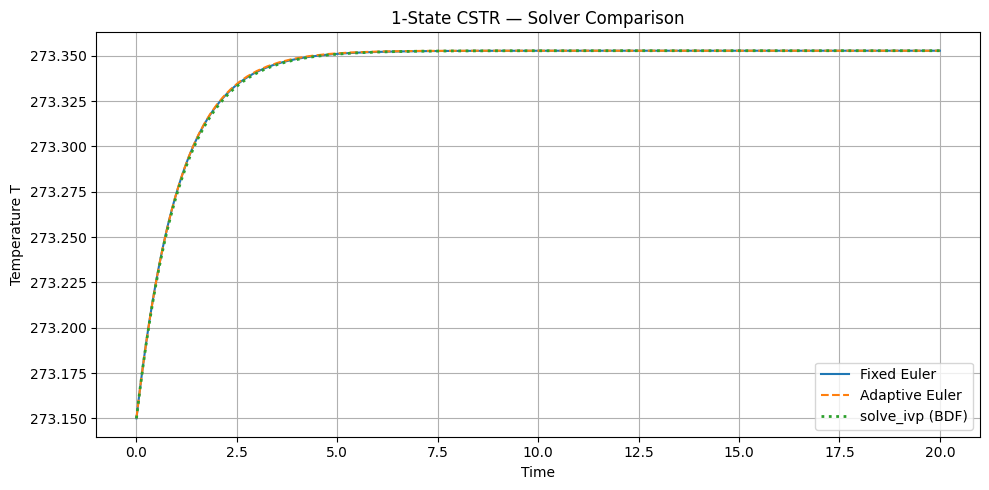

In [101]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(T_fixed, X_fixed[:], label='Fixed Euler', lw=1.5)
plt.plot(T_adapt, X_adapt[:], '--', label='Adaptive Euler', lw=1.5)
plt.plot(sol_ref.t, sol_ref.y[0], ':', label='solve_ivp (BDF)', lw=2)
plt.xlabel("Time")
plt.ylabel("Temperature T")
plt.title("1-State CSTR — Solver Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

PFR 1 state:

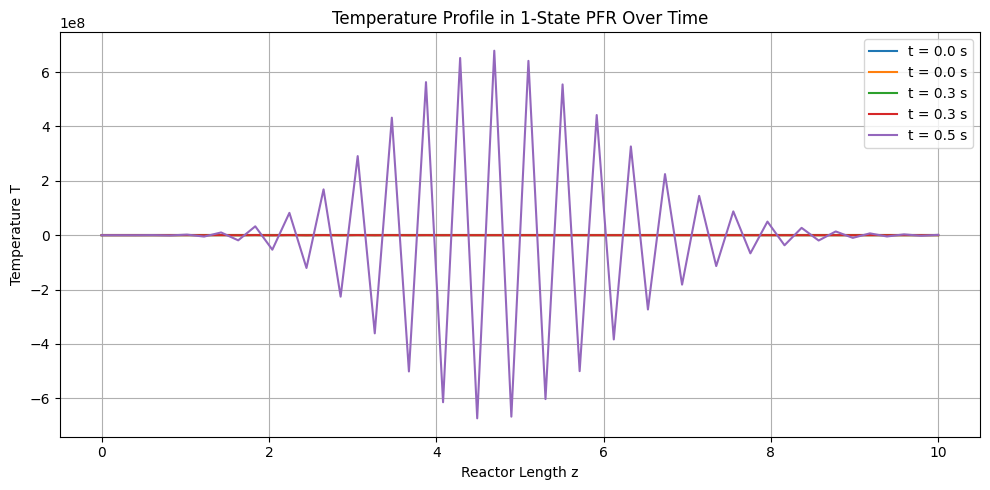

In [10]:
# Re-importing necessary modules after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Callable

# --- 1-state PFR model ---
def PFR1(t: float, T: np.ndarray, u: Callable[[float], float], p: dict) -> np.ndarray:
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))

    Tin_val = u(t)
    T_edge = np.concatenate([[Tin_val], T])
    NT = np.zeros(Nz + 1)
    for j in range(1, Nz + 1):
        NT[j] = v * T_edge[j - 1] - DT * (T_edge[j] - T_edge[j - 1]) / dz

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt

# --- Parameters ---
params = {
    "Nz": 50,
    "dz": 0.2,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T  # No reaction
}

# --- Initial and inlet temperature ---
T0 = np.ones(params["Nz"]) * 300.0
Tin = lambda t: 350.0

# --- Time span ---
tspan = (0, 0.5)
t_eval = np.linspace(*tspan, 10000000)

# --- Solve using solve_ivp ---
sol = solve_ivp(
    fun=lambda t, T: PFR1(t, T, Tin, params),
    t_span=tspan,
    y0=T0,
    t_eval=t_eval,
    method='BDF'
)

# --- Plot ---
z = np.linspace(0, params["Nz"] * params["dz"], params["Nz"])
time_indices = [0, 500000,5000000,5000000,9000000]

plt.figure(figsize=(10, 5))
for i in time_indices:
    plt.plot(z, sol.y[:, i], label=f't = {sol.t[i]:.1f} s')

plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("Temperature Profile in 1-State PFR Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


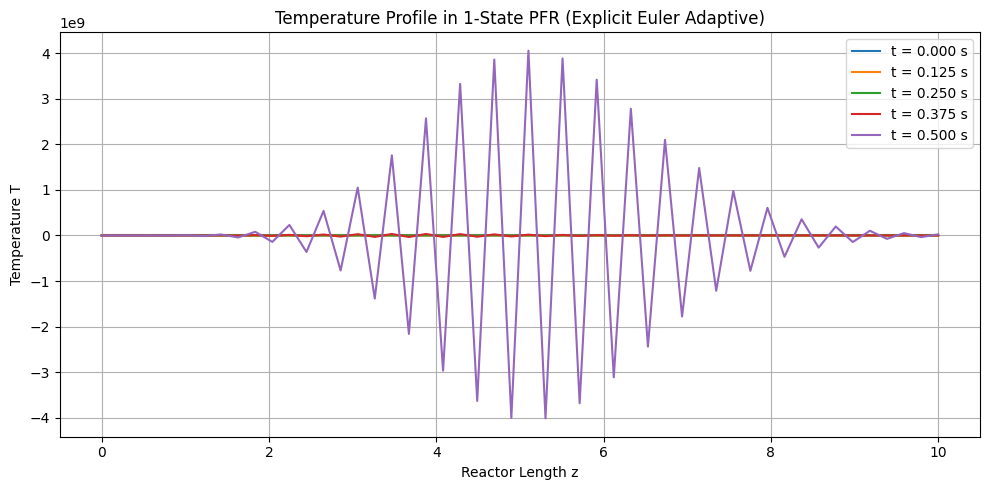

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# --- 1-state PFR model ---
def PFR1(t: float, T: np.ndarray, u: Callable[[float], float], p: dict) -> np.ndarray:
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))

    Tin_val = u(t)
    T_edge = np.concatenate([[Tin_val], T])
    NT = np.zeros(Nz + 1)
    for j in range(1, Nz + 1):
        NT[j] = v * T_edge[j - 1] - DT * (T_edge[j] - T_edge[j - 1]) / dz

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt

# --- Adaptive Explicit Euler (Vectorized for array state) ---
def ExplicitEulerAdaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0

    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)

    T = [t]
    X = [x.copy()]

    while t < tf:
        if t + h > tf:
            h = tf - t

        f = np.array(fun(t, x, *args))
        Accept = False

        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = np.array(fun(t + 0.5 * h, xm, *args))
            x1hat = xm + 0.5 * h * fm

            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)

            Accept = r <= epstol

            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())

            h = h * np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)

    return np.array(T), np.array(X)

# --- Parameters ---
params = {
    "Nz": 50,
    "dz": 0.2,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T  # No reaction
}

# Initial and inlet temperatures
T0 = np.ones(params["Nz"]) * 300.0
Tin = lambda t: 350.0

# Time settings
tspan = (0, 0.5)
h0 = 0.001
abstol = 1e-6
reltol = 1e-3

# --- Run adaptive solver ---
T_adapt, Y_adapt = ExplicitEulerAdaptive(PFR1, tspan, T0, h0, abstol, reltol, Tin, params)

# --- Plot results at selected times ---
z = np.linspace(0, params["Nz"] * params["dz"], params["Nz"])

# Choose 5 time steps approximately evenly spaced in time
sample_times = np.linspace(tspan[0], tspan[1], 5)
sample_indices = [np.argmin(np.abs(T_adapt - t)) for t in sample_times]

plt.figure(figsize=(10, 5))
for i in sample_indices:
    plt.plot(z, Y_adapt[i], label=f't = {T_adapt[i]:.3f} s')

plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("Temperature Profile in 1-State PFR (Explicit Euler Adaptive)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


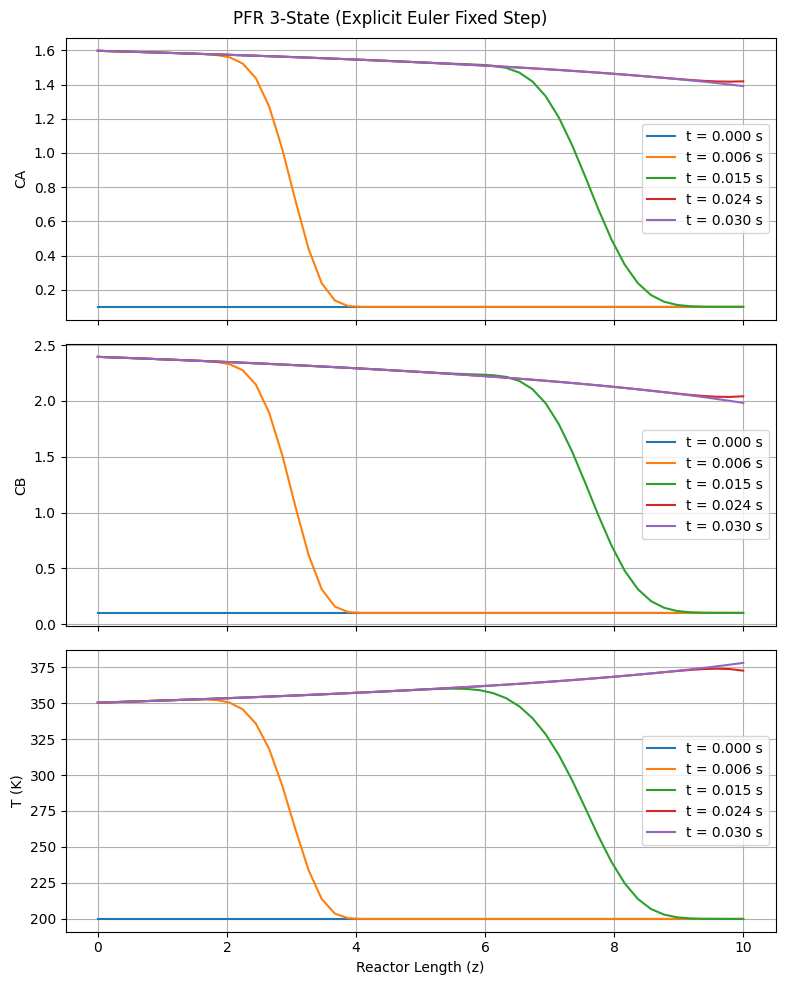

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- 3-state PFR model ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    k0 = np.exp(24.6)
    DA = 0.1
    DB = 0.1
    DT = 0.1
    Ea_over_R = 8500

    CA = C[:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]

    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    # Convection + diffusion
    def flux(Cj, Dj, Cin_j):
        N = np.zeros(n+1)
        J = np.zeros(n+1)
        N[0] = vol * Cin_j
        N[1:] = vol * Cj
        J[1:n] = (-Dj / dz) * (Cj[1:] - Cj[:-1])
        return N + J

    NA = flux(CA, DA, CAin)
    NB = flux(CB, DB, CBin)
    NT = flux(T, DT, Tin)

    RA = p['v_vec'][0] * r
    RB = p['v_vec'][1] * r
    RT = p['v_vec'][2] * r

    dCA = (NA[1:] - NA[:-1]) / -dz + RA
    dCB = (NB[1:] - NB[:-1]) / -dz + RB
    dT = (NT[1:] - NT[:-1]) / -dz + RT

    return np.concatenate([dCA, dCB, dT])


# --- Fixed step Euler (your version) ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X


# --- Parameters ---
Nz = 50
L = 10
dz = L / Nz
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v_vec = np.array([-1, -2, beta])
F = 50
Cin = np.array([1.6, 2.4, 350])

params = {
    'Nz': Nz,
    'dz': dz,
    'v': np.zeros(Nz),  # dummy, not used
    'F': F,
    'v_vec': v_vec
}

# Initial values
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# --- Solve ---
tspan = (0, 0.03)
N_steps = 100
T, X = explicit_euler_fixed_step_size(PFR_3state, *tspan, N_steps, C0, Cin, params)
T_adapt, X_adapt = explicit_euler_adaptive_step(PFR_3state, tspan, C0, 0.001, 1e-6, 1e-3, Cin, params)

# --- Plot ---
z = np.linspace(0, L, Nz)
time_indices = [0, int(N_steps*0.2), int(N_steps*0.5), int(N_steps*0.8), N_steps]

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

for i in time_indices:
    CA = X[i, 0:Nz]
    CB = X[i, Nz:2*Nz]
    T_profile = X[i, 2*Nz:3*Nz]
    axs[0].plot(z, CA, label=f't = {T[i]:.3f} s')
    axs[1].plot(z, CB, label=f't = {T[i]:.3f} s')
    axs[2].plot(z, T_profile, label=f't = {T[i]:.3f} s')

axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')

for ax in axs:
    ax.grid(True)
    ax.legend()

fig.suptitle('PFR 3-State (Explicit Euler Fixed Step)')
plt.tight_layout()
plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags, bmat

# --- PFR 3-State ODE system ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n, dz, v, F = p['Nz'], p['dz'], p['v'], p['F']
    k0, DA, DB, DT = np.exp(24.6), 0.1, 0.1, 0.1
    Ea_over_R = 8500

    CA = C[:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    def flux(C, D, Cin_):
        N = np.zeros(n+1)
        J = np.zeros(n+1)
        N[0] = F * Cin_
        N[1:] = F * C
        J[1:n] = (-D / dz) * (C[1:] - C[:-1])
        return N + J

    NA = flux(CA, DA, CAin)
    NB = flux(CB, DB, CBin)
    NT = flux(T, DT, Tin)

    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    dCA = (NA[1:] - NA[:-1]) / -dz + RA
    dCB = (NB[1:] - NB[:-1]) / -dz + RB
    dT  = (NT[1:] - NT[:-1]) / -dz + RT

    return np.concatenate([dCA, dCB, dT])

# --- Jacobian ---
def jacobian_PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n, dz, v, F = p['Nz'], p['dz'], p['v'], p['F']
    k0, DA, DB, DT = np.exp(24.6), 0.1, 0.1, 0.1
    Ea_over_R = 8500

    CA = C[:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    dr_dCA = k * CB
    dr_dCB = k * CA
    dr_dT = k * CA * CB * Ea_over_R / T**2

    def spatial_matrix(D):
        main = (-2 * D) / dz**2 * np.ones(n)
        off = (D) / dz**2 * np.ones(n - 1)
        return diags([off, main, off], offsets=[-1, 0, 1], format='csr')

    JAA = spatial_matrix(DA) + diags(v[0] * dr_dCA)
    JAB = diags(v[0] * dr_dCB)
    JAT = diags(v[0] * dr_dT)

    JBA = diags(v[1] * dr_dCA)
    JBB = spatial_matrix(DB) + diags(v[1] * dr_dCB)
    JBT = diags(v[1] * dr_dT)

    JTA = diags(v[2] * dr_dCA)
    JTB = diags(v[2] * dr_dCB)
    JTT = spatial_matrix(DT) + diags(v[2] * dr_dT)

    return bmat([[JAA, JAB, JAT], [JBA, JBB, JBT], [JTA, JTB, JTT]], format='csr')

# --- Explicit Euler Fixed Step ---
def explicit_euler_fixed_step(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Explicit Euler Adaptive Step ---
def explicit_euler_adaptive_step(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = x0.copy()
    T = [t]
    X = [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = fun(t, x, *args)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = fun(t + 0.5 * h, xm, *args)
            x1hat = xm + 0.5 * h * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

# --- Settings ---
Nz = 50
L = 1
dz = L / Nz
v = np.array([-1, -2, -560 / (1.0 * 4.186)])
p = {'Nz': Nz, 'dz': dz, 'v': v, 'F': 0.1}
Cin = np.array([1.6, 2.4, 350])
C0 = np.concatenate([np.full(Nz, 0.1), np.full(Nz, 0.1), np.full(Nz, 200)])
tspan = (0, 0.5)
t_eval = np.linspace(*tspan, 100)

# --- Solve all three methods ---
T_fix, X_fix = explicit_euler_fixed_step(PFR_3state, tspan[0], tspan[1], 500, C0, Cin, p)
T_adp, X_adp = explicit_euler_adaptive_step(PFR_3state, tspan, C0, 1e-3, 1e-6, 1e-3, Cin, p)
sol_ref = solve_ivp(lambda t, x: PFR_3state(t, x, Cin, p), tspan, C0, t_eval=t_eval, method='BDF', jac=lambda t, x: jacobian_PFR_3state(t, x, Cin, p))

# --- Plot ---
z = np.linspace(0, L, Nz)



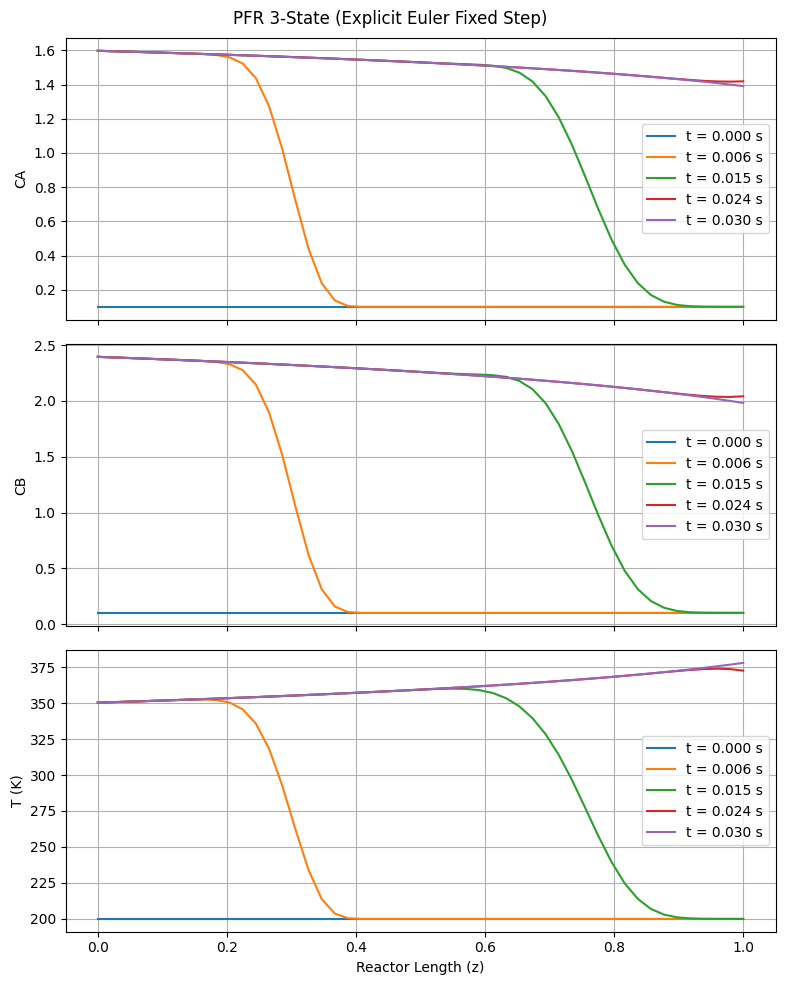

In [35]:
z = np.linspace(0, L, Nz)
time_indices = [0, int(N_steps*0.2), int(N_steps*0.5), int(N_steps*0.8), N_steps]

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

for i in time_indices:
    CA = X[i, 0:Nz]
    CB = X[i, Nz:2*Nz]
    T_profile = X[i, 2*Nz:3*Nz]
    axs[0].plot(z, CA, label=f't = {T[i]:.3f} s')
    axs[1].plot(z, CB, label=f't = {T[i]:.3f} s')
    axs[2].plot(z, T_profile, label=f't = {T[i]:.3f} s')

axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')

for ax in axs:
    ax.grid(True)
    ax.legend()

fig.suptitle('PFR 3-State (Explicit Euler Fixed Step)')
plt.tight_layout()
plt.show()

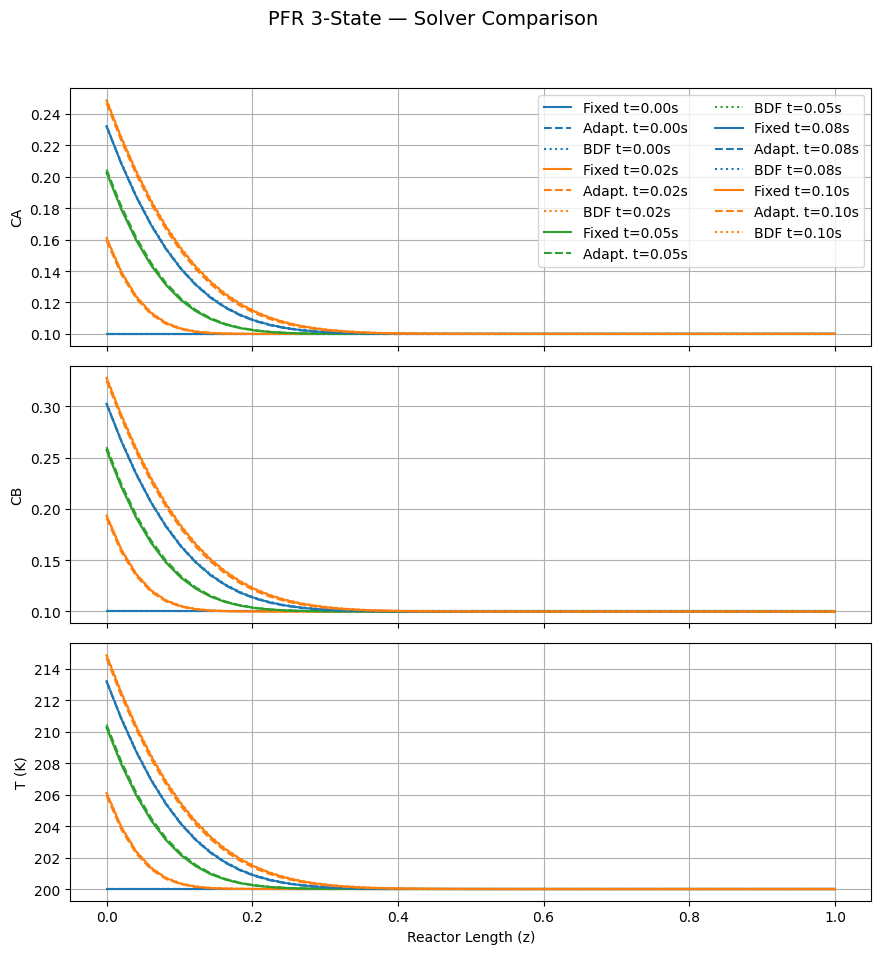

In [37]:
# Assume: T_fix, X_fix, T_adp, X_adp, sol_ref (BDF), and Nz, z, etc. already defined

selected_times = [0.0, 0.02, 0.05, 0.08, 0.1]  # Time points to plot
labels = ["Fixed", "Adapt.", "BDF"]
styles = ['-', '--', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, axs = plt.subplots(3, 1, figsize=(9, 10), sharex=True)

for i, t_target in enumerate(selected_times):
    idx_fix = np.argmin(np.abs(T_fix - t_target))
    idx_adp = np.argmin(np.abs(T_adp - t_target))
    idx_bdf = np.argmin(np.abs(sol_ref.t - t_target))

    CA_fix = X_fix[idx_fix, 0:Nz]
    CB_fix = X_fix[idx_fix, Nz:2*Nz]
    T_fix_prof = X_fix[idx_fix, 2*Nz:3*Nz]

    CA_adp = X_adp[idx_adp, 0:Nz]
    CB_adp = X_adp[idx_adp, Nz:2*Nz]
    T_adp_prof = X_adp[idx_adp, 2*Nz:3*Nz]

    CA_bdf = sol_ref.y[0:Nz, idx_bdf]
    CB_bdf = sol_ref.y[Nz:2*Nz, idx_bdf]
    T_bdf_prof = sol_ref.y[2*Nz:3*Nz, idx_bdf]

    axs[0].plot(z, CA_fix, styles[0], color=colors[i % len(colors)], label=f'{labels[0]} t={t_target:.2f}s')
    axs[0].plot(z, CA_adp, styles[1], color=colors[i % len(colors)], label=f'{labels[1]} t={t_target:.2f}s')
    axs[0].plot(z, CA_bdf, styles[2], color=colors[i % len(colors)], label=f'{labels[2]} t={t_target:.2f}s')

    axs[1].plot(z, CB_fix, styles[0], color=colors[i % len(colors)])
    axs[1].plot(z, CB_adp, styles[1], color=colors[i % len(colors)])
    axs[1].plot(z, CB_bdf, styles[2], color=colors[i % len(colors)])

    axs[2].plot(z, T_fix_prof, styles[0], color=colors[i % len(colors)])
    axs[2].plot(z, T_adp_prof, styles[1], color=colors[i % len(colors)])
    axs[2].plot(z, T_bdf_prof, styles[2], color=colors[i % len(colors)])

axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')

for ax in axs:
    ax.grid(True)

axs[0].legend(ncol=2)
fig.suptitle('PFR 3-State — Solver Comparison ', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


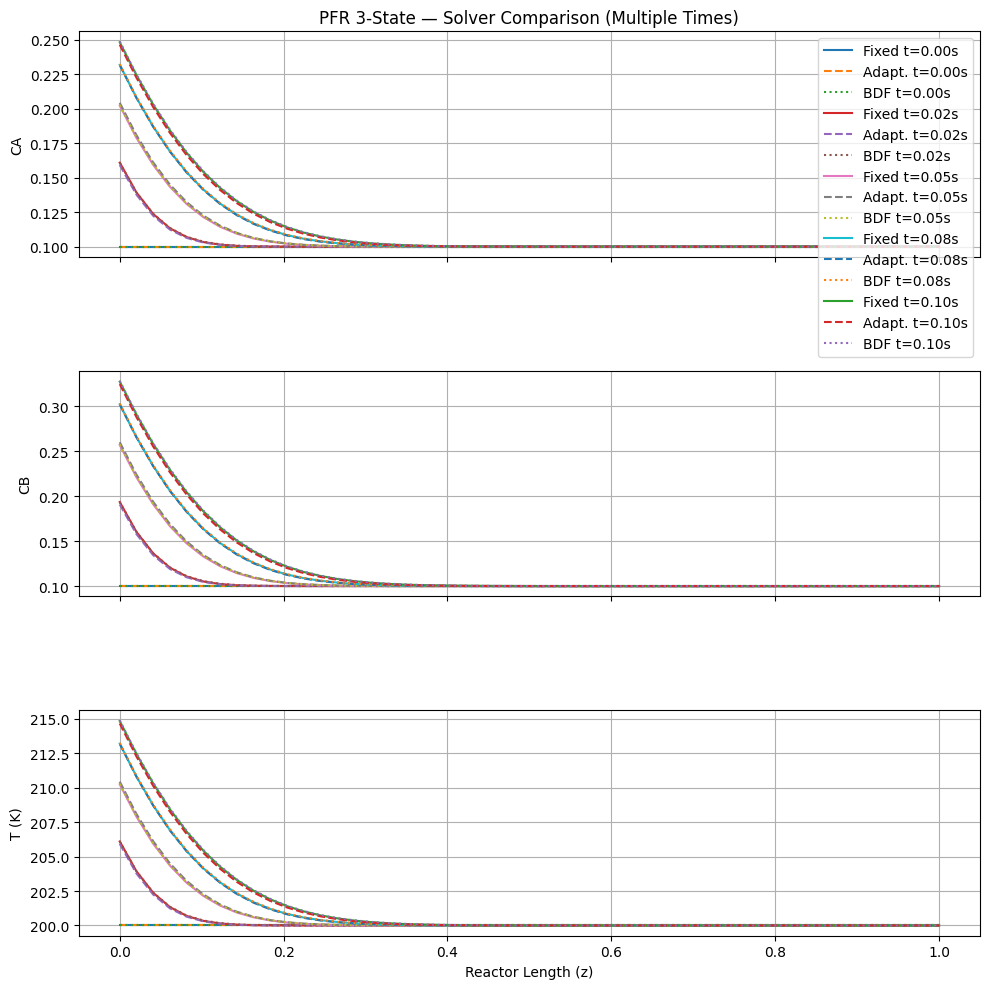

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Spatial domain
z = np.linspace(0, L, Nz)
time_indices = [0, 300, 499,800]

# Pick 5 indices for plotting (based on fixed-step solution)
time_indices_fix = [0, int(N_steps * 0.2), int(N_steps * 0.5), int(N_steps * 0.8), N_steps]
time_values = [T_fix[i] for i in time_indices_fix]

# Find closest indices in adaptive and BDF solutions
time_indices_adp = [np.argmin(np.abs(T_adp - t)) for t in time_values]
time_indices_ref = [np.argmin(np.abs(sol_ref.t - t)) for t in time_values]

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

for fix_i, adp_i, ref_i, t in zip(time_indices_fix, time_indices_adp, time_indices_ref, time_values):
    # Extract profiles
    CA_fix = X_fix[fix_i][:Nz]
    CB_fix = X_fix[fix_i][Nz:2*Nz]
    T_fix_ = X_fix[fix_i][2*Nz:3*Nz]

    CA_adp = X_adp[adp_i][:Nz]
    CB_adp = X_adp[adp_i][Nz:2*Nz]
    T_adp_ = X_adp[adp_i][2*Nz:3*Nz]

    CA_ref = sol_ref.y[:Nz, ref_i]
    CB_ref = sol_ref.y[Nz:2*Nz, ref_i]
    T_ref = sol_ref.y[2*Nz:3*Nz, ref_i]

    # Plot CA
    axs[0].plot(z, CA_fix, label=f'Fixed t={t:.2f}s', linestyle='-')
    axs[0].plot(z, CA_adp, '--', label=f'Adapt. t={t:.2f}s')
    axs[0].plot(z, CA_ref, ':', label=f'BDF t={t:.2f}s')

    # Plot CB
    axs[1].plot(z, CB_fix, linestyle='-')
    axs[1].plot(z, CB_adp, linestyle='--')
    axs[1].plot(z, CB_ref, linestyle=':')

    # Plot T
    axs[2].plot(z, T_fix_, linestyle='-')
    axs[2].plot(z, T_adp_, linestyle='--')
    axs[2].plot(z, T_ref, linestyle=':')

# Labeling
axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')
axs[0].legend()
axs[0].set_title('PFR 3-State — Solver Comparison (Multiple Times)')

for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()


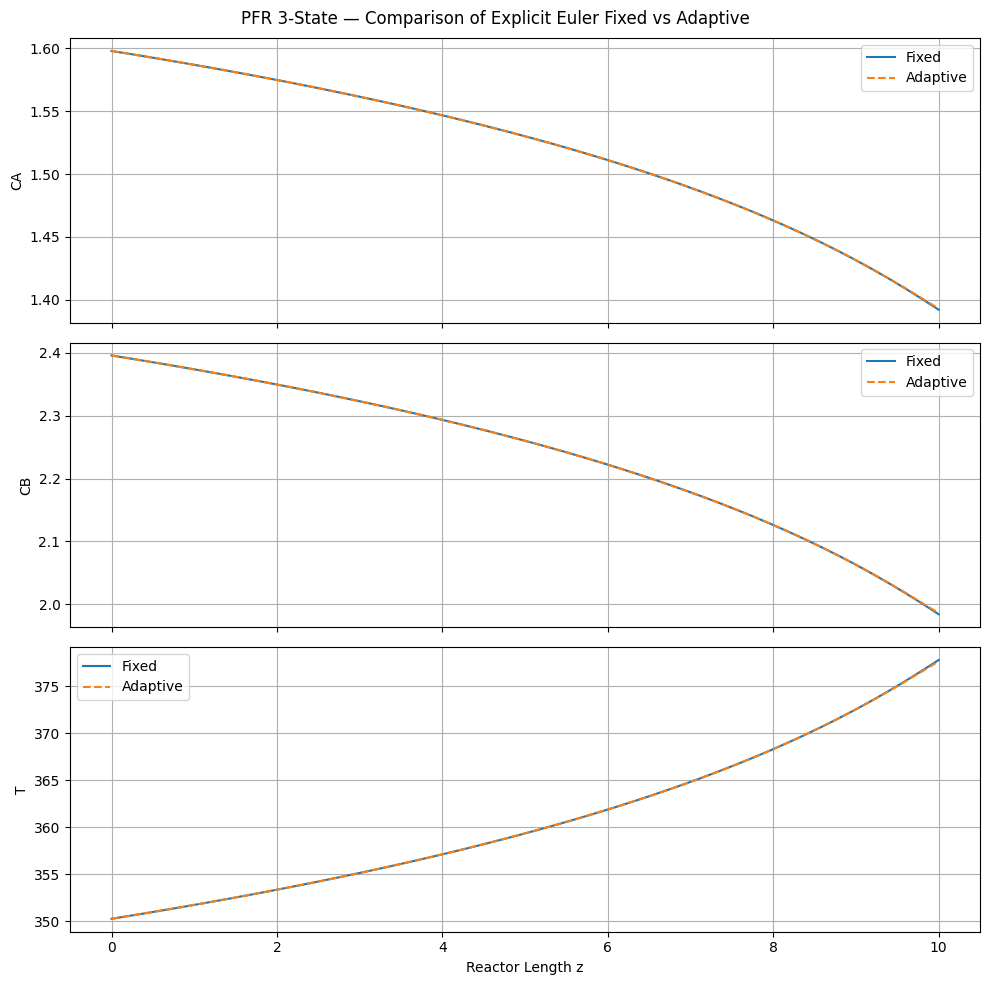

In [22]:
z = np.linspace(0, L, Nz)

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fields = ["CA", "CB", "T"]
for i, ax in enumerate(axs):
    for label, T_vals, X_vals, style in [
        ("Fixed", T_fixed, X_fixed, "-"),
        ("Adaptive", T_adapt, X_adapt, "--")
    ]:
        idx = len(T_vals) - 1
        if label == "Fixed":
            Y = X_vals[idx]
        else:
            Y = X_vals[-1]
        ax.plot(z, Y[i * Nz:(i + 1) * Nz], style, label=label)
    ax.set_ylabel(fields[i])
    ax.grid(True)
    ax.legend()

axs[2].set_xlabel("Reactor Length z")
fig.suptitle("PFR 3-State — Comparison of Explicit Euler Fixed vs Adaptive")
plt.tight_layout()

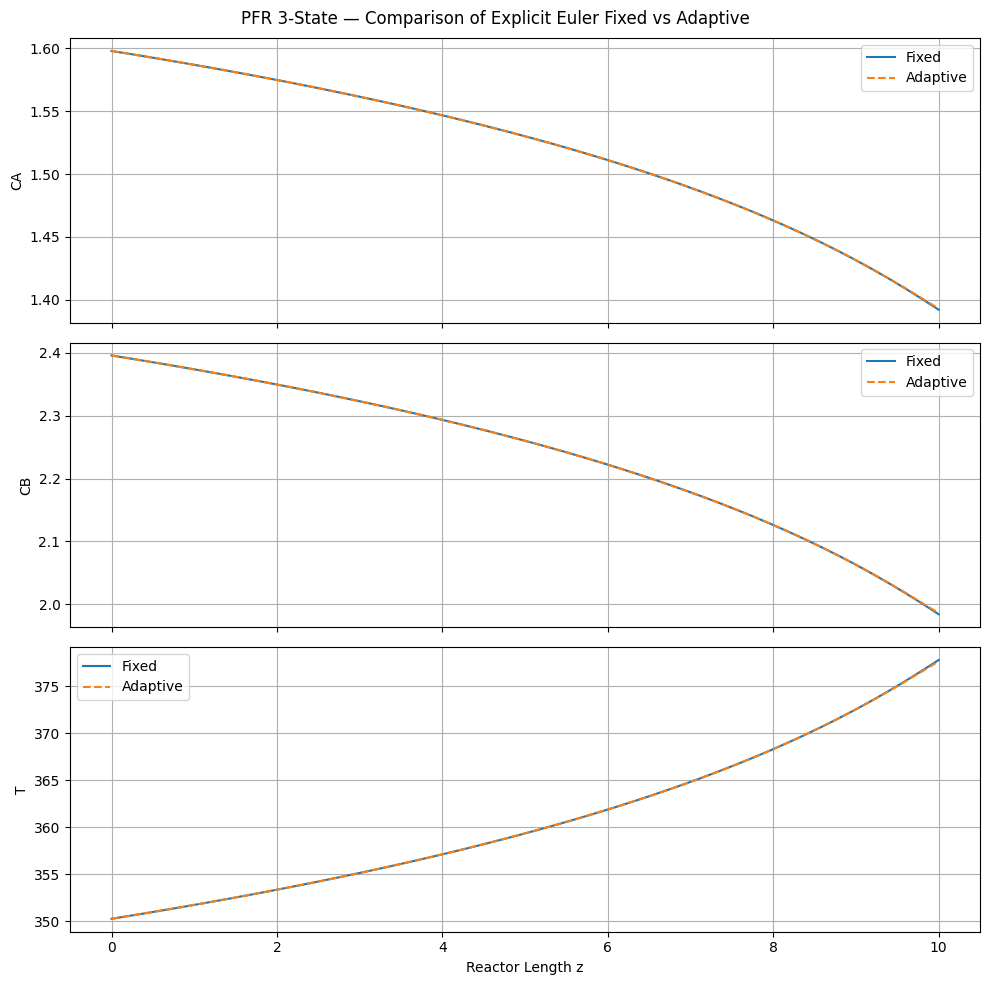

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- 3-state PFR model ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    k0 = np.exp(24.6)
    DA = 0.1
    DB = 0.1
    DT = 0.1
    Ea_over_R = 8500

    CA = C[:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]

    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    def flux(Cj, Dj, Cin_j):
        N = np.zeros(n+1)
        J = np.zeros(n+1)
        N[0] = vol * Cin_j
        N[1:] = vol * Cj
        J[1:n] = (-Dj / dz) * (Cj[1:] - Cj[:-1])
        return N + J

    NA = flux(CA, DA, CAin)
    NB = flux(CB, DB, CBin)
    NT = flux(T, DT, Tin)

    RA = p['v_vec'][0] * r
    RB = p['v_vec'][1] * r
    RT = p['v_vec'][2] * r

    dCA = (NA[1:] - NA[:-1]) / -dz + RA
    dCB = (NB[1:] - NB[:-1]) / -dz + RB
    dT = (NT[1:] - NT[:-1]) / -dz + RT

    return np.concatenate([dCA, dCB, dT])

# --- Explicit Euler Fixed Step ---
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

# --- Explicit Euler Adaptive Step ---
def explicit_euler_adaptive_step(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)
    T = [t]
    X = [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args))
        x1 = x + h * f
        xm = x + 0.5 * h * f
        fm = np.array(fun(t + 0.5 * h, xm, *args))
        x1hat = xm + 0.5 * h * fm
        e = x1hat - x1
        denom = np.maximum(abstol, np.abs(x1hat) * reltol)
        r = np.max(np.abs(e) / denom)
        if r <= epstol:
            t += h
            x = x1hat
            T.append(t)
            X.append(x.copy())
        h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

# --- Parameters ---
Nz = 50
L = 10
dz = L / Nz
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v_vec = np.array([-1, -2, beta])
F = 50
Cin = np.array([1.6, 2.4, 350])
params = {'Nz': Nz, 'dz': dz, 'v': np.zeros(Nz), 'F': F, 'v_vec': v_vec}

# Initial state
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# --- Time settings ---
tspan = (0, 0.03)
N_steps = 200

# --- Solve both ---
T_fixed, X_fixed = explicit_euler_fixed_step_size(PFR_3state, *tspan, N_steps, C0, Cin, params)
T_adapt, X_adapt = explicit_euler_adaptive_step(PFR_3state, tspan, C0, 0.001, 1e-6, 1e-3, Cin, params)

# --- Plot ---
z = np.linspace(0, L, Nz)

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fields = ["CA", "CB", "T"]
for i, ax in enumerate(axs):
    for label, T_vals, X_vals, style in [
        ("Fixed", T_fixed, X_fixed, "-"),
        ("Adaptive", T_adapt, X_adapt, "--")
    ]:
        idx = len(T_vals) - 1
        if label == "Fixed":
            Y = X_vals[idx]
        else:
            Y = X_vals[-1]
        ax.plot(z, Y[i * Nz:(i + 1) * Nz], style, label=label)
    ax.set_ylabel(fields[i])
    ax.grid(True)
    ax.legend()

axs[2].set_xlabel("Reactor Length z")
fig.suptitle("PFR 3-State — Comparison of Explicit Euler Fixed vs Adaptive")
plt.tight_layout()
plt.show()


# stability plot!

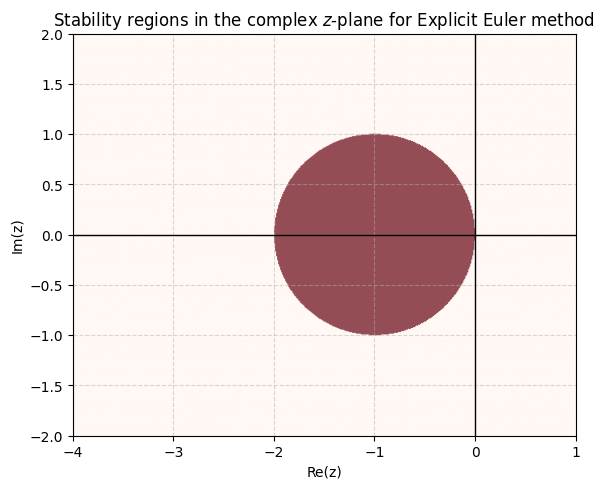

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Grid in complex plane
x = np.linspace(-4, 1, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Region where Euler is stable: |1 + z| <= 1
stability_region = np.abs(1 + Z) <= 1

# Plot with imshow
plt.figure(figsize=(6, 6))
plt.imshow(
    stability_region,
    extent=[x.min(), x.max(), y.min(), y.max()],
    origin='lower',
    cmap='Reds',
    alpha=0.7
)
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title("Stability regions in the complex $z$-plane for Explicit Euler method")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# RK4 stability function
def R(z):
    return 1 + z + z**2/2 + z**3/6 + z**4/24

# Meshgrid for complex plane
x = np.linspace(-4, 4, 800)
y = np.linspace(-4, 4, 800)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate the magnitude of the stability function
R_vals = R(Z)
stability = np.abs(R_vals) <= 1



STability plot runge kutta

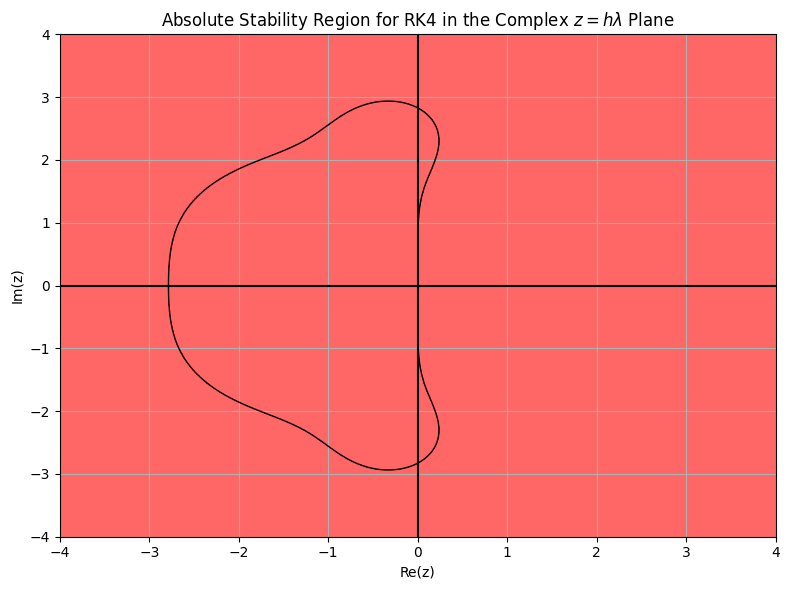

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define the RK4 stability function R(z)
def R(z):
    return 1 + z + z**2 / 2 + z**3 / 6 + z**4 / 24

# Create a grid of complex numbers z = x + iy
x = np.linspace(-4, 4, 800)
y = np.linspace(-4, 4, 800)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate the magnitude of R(z)
R_vals = np.abs(R(Z))

# Plotting the stability region: where |R(z)| <= 1
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, R_vals <= 1, levels=1, colors=["red"], alpha=0.6)
plt.contour(X, Y, R_vals, levels=[1], colors='black', linewidths=1)

# Plot formatting
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Absolute Stability Region for RK4 in the Complex $z = h\\lambda$ Plane")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(True)
plt.tight_layout()
plt.show()


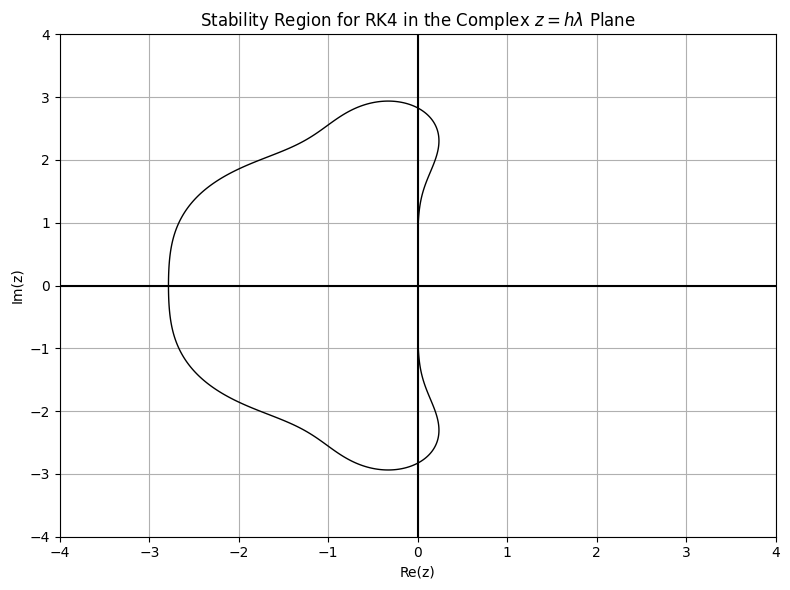

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define the RK4 stability function R(z)
def R(z):
    return 1 + z + z**2 / 2 + z**3 / 6 + z**4 / 24

# Create a grid of complex numbers z = x + iy
x = np.linspace(-4, 4, 800)
y = np.linspace(-4, 4, 800)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate the magnitude of R(z)
R_vals = np.abs(R(Z))

# Plot only the boundary where |R(z)| = 1
plt.figure(figsize=(8, 6))
plt.contour(X, Y, R_vals, levels=[1], colors='black', linewidths=1)

# Plot formatting
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Stability Region for RK4 in the Complex $z = h\\lambda$ Plane")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(True)
plt.tight_layout()
plt.show()
